In [106]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
from plotly.subplots import make_subplots
import talib
import colored
import os
import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
if not os.path.exists("images"):
    os.mkdir("images")

In [126]:
os.listdir("../data")

['12hours.csv',
 '15minute.csv',
 '1day.csv',
 '1hour.csv',
 '1hours.csv',
 '1minute.csv',
 '1minutes.csv',
 '30minute.csv',
 '3minute.csv',
 '3minute_test.csv',
 '4hour.csv',
 '5minute.csv',
 'BitcoinM15.csv',
 'bnb5minute.csv',
 'btc_test_1.csv',
 'data.csv',
 'eth5minute.csv',
 'EURUSDM15.csv',
 'new_test_1hours.csv',
 'test.csv',
 'test1hour.csv',
 'test_1h.csv',
 'test_1hours.csv',
 'test_3m.csv',
 'test_5m.csv',
 'train(1).csv',
 'train.csv',
 'train1hour.csv',
 'train_1h.csv',
 'train_1hours.csv',
 'train_3m.csv',
 'train_5m.csv',
 'XAUUSD.csv',
 'XAUUSD1440.csv',
 'XAUUSD15.csv',
 'XAUUSD60.csv',
 'XAUUSDH1.csv',
 'XAUUSDM15.csv',
 'XAUUSD_Daily_Train.csv']

In [145]:
# df = pd.read_csv("../data/XAUUSDH1.csv", parse_dates=[['Date', 'Time']])
df = pd.read_csv("../data/XAUUSDH1.csv")

In [146]:
# df = df[-500:].reset_index(drop=True)
df.head()

,Date_Time,Open,High,Low,Close,Volume
0,2016.02.22 21:00,1208.88,1209.56,1207.76,1207.79,2084
1,2016.02.22 22:00,1207.78,1209.49,1207.28,1207.43,2290
2,2016.02.22 23:00,1207.38,1208.95,1207.36,1208.47,1089
3,2016.02.23 01:00,1208.32,1209.57,1207.25,1208.86,1031
4,2016.02.23 02:00,1209.05,1211.47,1207.23,1210.80,4914


In [147]:
from talib import EMA
df['EMA'] = talib.EMA(df.Close, timeperiod=200)
df['DX'] = talib.DX(df.High, df.Low, df.Close, timeperiod=14)
df['RSI'] = talib.RSI(df.Close, timeperiod=14)

In [148]:
#SuperTrend
def ST(df,f,n): #df is the dataframe, n is the period, f is the factor; f=3, n=7 are commonly used.
    #Calculation of ATR
    col_name = f"SuperTrend{f}{n}"
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas verion- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    
    #Calculation of SuperTrend
    df['Upper Basic']=(df['High']+df['Low'])/2+(f*df['ATR'])
    df['Lower Basic']=(df['High']+df['Low'])/2-(f*df['ATR'])
    df['Upper Band']=df['Upper Basic']
    df['Lower Band']=df['Lower Basic']
    for i in range(n,len(df)):
        if df['Close'][i-1]<=df['Upper Band'][i-1]:
            df['Upper Band'][i]=min(df['Upper Basic'][i],df['Upper Band'][i-1])
        else:
            df['Upper Band'][i]=df['Upper Basic'][i]    
    for i in range(n,len(df)):
        if df['Close'][i-1]>=df['Lower Band'][i-1]:
            df['Lower Band'][i]=max(df['Lower Basic'][i],df['Lower Band'][i-1])
        else:
            df['Lower Band'][i]=df['Lower Basic'][i]   
    df[col_name]=np.nan
    for i in df[col_name]:
        if df['Close'][n-1]<=df['Upper Band'][n-1]:
            df[col_name][n-1]=df['Upper Band'][n-1]
        elif df['Close'][n-1]>df['Upper Band'][i]:
            df[col_name][n-1]=df['Lower Band'][n-1]
    for i in range(n,len(df)):
        if df[col_name][i-1]==df['Upper Band'][i-1] and df['Close'][i]<=df['Upper Band'][i]:
            df[col_name][i]=df['Upper Band'][i]
        elif  df[col_name][i-1]==df['Upper Band'][i-1] and df['Close'][i]>=df['Upper Band'][i]:
            df[col_name][i]=df['Lower Band'][i]
        elif df[col_name][i-1]==df['Lower Band'][i-1] and df['Close'][i]>=df['Lower Band'][i]:
            df[col_name][i]=df['Lower Band'][i]
        elif df[col_name][i-1]==df['Lower Band'][i-1] and df['Close'][i]<=df['Lower Band'][i]:
            df[col_name][i]=df['Upper Band'][i]
    return df

In [149]:
def get_trend(close_p: float, sp_trend_1: float, sp_trend_2: float, sp_trend_3: float) -> str:
    if close_p > sp_trend_1 and close_p > sp_trend_2 and close_p > sp_trend_3:
        return "Buy"
    if close_p < sp_trend_1 and close_p < sp_trend_2 and close_p < sp_trend_3:
        return "Sell"
    return "No Trend"


def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1] and \
        df['Low'][i] < df['Low'][i+1] and \
        df['Low'][i+1] < df['Low'][i+2] and \
        df['Low'][i-1] < df['Low'][i-2]

    return support


def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and \
        df['High'][i] > df['High'][i+1] and \
        df['High'][i+1] > df['High'][i+2] and \
        df['High'][i-1] > df['High'][i-2] 

    return resistance


def isFarFromLevel(l, s):
    return np.sum([abs(l-x[1]) < s  for x in levels]) == 0


def calculate_support_registance(start, stop):
    levels = []
    df_new = df.iloc[start:stop].reset_index(drop=True)
    s =  np.mean(df_new['High'] - df_new['Low'])
    for i in range(2,df_new.shape[0]-2):
        if isSupport(df_new,i):
            l = df_new['Low'][i]
            if isFarFromLevel(l, s):
                levels.append((i,l, 'Support'))

        elif isResistance(df_new,i):
            l = df_new['High'][i]
            if isFarFromLevel(l, s):
                levels.append((i,l, 'Resistance'))
    return levels
def save_result(order_index, scan_index, diff, close_p, levels=None):
    if scan_index > 200:
        new_df = df.iloc[order_index-20:scan_index+20]
        data=[
            go.Candlestick(x=new_df['Date_Time'], open=new_df['Open'], high=new_df['High'], low=new_df['Low'], close=new_df['Close']),
            go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend312'], mode='lines', name='SuperTrend312'),
            go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend110'], mode='lines', name='SuperTrend110'),
            go.Scatter(x=new_df['Date_Time'], y=new_df['SuperTrend211'], mode='lines', name='SuperTrend211'),
            go.Scatter(x=[new_df['Date_Time'].loc[order_index]], y=[new_df['Close'].loc[order_index]], mode='markers'),
            go.Scatter(x=[new_df['Date_Time'].loc[scan_index]], y=[close_p], mode='markers')
        ]
        if levels:
            for level in levels:
                line_color = 'green' if level[2] == 'Resistance' else 'red'
                data.append(go.Scatter(x=new_df['Date_Time'][:level[0]], y=[level[1]]*level[0], mode='lines', line_color=line_color, name=f'{level[2]} {level[1]}'))
        fig = go.Figure(data)
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.write_image(f"images/{scan_index}_{round(diff, 1)}.png")

In [150]:
# n is the period, f is the factor; f=3, n=7 are commonly used.
df = ST(df, f=3,n=12)
df = ST(df, f=1,n=10)
df = ST(df, f=2,n=11)

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\ipykern

In [151]:
df.tail()

,Date_Time,Open,High,Low,Close,Volume,EMA,DX,RSI,H-L,...,L-PC,TR,ATR,Upper Basic,Lower Basic,Upper Band,Lower Band,SuperTrend312,SuperTrend110,SuperTrend211
30594,2021.05.03 12:00,1775.59,1779.01,1775.30,1777.71,4947,1773.330355,38.087145,60.995134,3.71,...,0.29,3.71,3.668234,1784.491467,1769.818533,1779.887239,1771.117075,1767.305008,1774.907405,1771.117075
30595,2021.05.03 13:00,1777.71,1782.71,1776.99,1778.15,5211,1773.378312,47.697313,61.719579,5.72,...,0.72,5.72,3.854758,1787.559515,1772.140485,1779.887239,1772.140485,1768.287880,1775.988948,1772.140485
30596,2021.05.03 14:00,1778.15,1781.70,1777.47,1781.00,5303,1773.454150,47.697313,66.110258,4.23,...,0.68,4.23,3.888871,1787.362741,1771.807259,1779.887239,1772.140485,1768.287880,1775.988948,1772.140485
30597,2021.05.03 15:00,1781.01,1787.01,1779.27,1784.54,9470,1773.564457,58.435576,70.618183,7.74,...,1.73,7.74,4.238973,1791.617947,1774.662053,1791.617947,1774.662053,1770.520232,1778.857848,1774.662053
30598,2021.05.03 16:00,1784.54,1788.69,1784.54,1788.69,3416,1773.714960,61.153056,74.842908,4.15,...,0.00,4.15,4.230885,1795.076770,1778.153230,1791.617947,1778.153230,1774.009380,1782.346063,1778.153230


In [152]:
# fig = go.Figure(data=[
#     go.Candlestick(x=df['Date_Time'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close']),
#     go.Scatter(x=df['Date_Time'], y=df['SuperTrend312'], mode='lines'),
#     go.Scatter(x=df['Date_Time'], y=df['SuperTrend110'], mode='lines'),
#     go.Scatter(x=df['Date_Time'], y=df['SuperTrend211'], mode='lines')
# ])

# # fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [153]:
# fig = go.Figure(data=[go.Scatter(y=df['ATR'])])
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [154]:
# fig = go.Figure(data=[go.Scatter(y=df['DX'])])
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [189]:
df.SuperTrend312.tail(1)

30598    1774.00938
Name: SuperTrend312, dtype: float64

In [190]:
X = []
y = []
order_p = None
order_size = None
order_index = None
profit = 0
max_profit = 0
max_loss = 0
num_loss = 0
num_profit = 0
stop_loss = None
all_profit = []
with_ema = True
with_stoploss = True
with_dx = True
dx_threshold = 20
cost = 0.1
lock_back_frame = 5
max_diff = 0
threshold = 0.95
for dfindex, date_time, close_p, high_p, low_p, atr, sp_trend_1, sp_trend_2, sp_trend_3, ema_200, dx in zip(df.index, df.Date_Time, df.Close, df.High, df.Low, df.ATR, df.SuperTrend312, df.SuperTrend110, df.SuperTrend211, df.EMA, df.DX):
    current_trend = get_trend(close_p, sp_trend_1, sp_trend_2, sp_trend_3)
    if current_trend == "Buy":
        if order_size == 'Sell':
            # close sell order if exist
            real_price = min([stop_loss, close_p])
            diff = order_p - real_price - cost
            profit += diff
            print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {real_price}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
            all_profit.append(profit)
            if diff < 0:
                max_loss += diff
                num_loss += 1
            else:
                max_profit += diff
                num_profit += 1

            # create data frame for predict outcome
#             if diff > 0:
#                 label = 0
#                 x_test = df.RSI.iloc[order_index-lock_back_frame:order_index]
#                 if len(x_train) == lock_back_frame:
#                     X.append(x_test)
#                     y.append(label)

            # save to debug
            save_result(order_index, dfindex, diff, real_price)

            # reset flags
            order_p = None
            order_size = None
            stop_loss = None
            order_index = None
            max_diff = 0
        if order_p is None:
            if close_p > ema_200:
#             x_train = df.RSI.iloc[dfindex-lock_back_frame:dfindex]
#             if len(x_train) == lock_back_frame:
#                 proba = model.predict(np.expand_dims(np.array(x_train).reshape(-1, 1), axis=0))
#                 proba = np.amax(proba)
#                 if proba > threshold:
    #             if close_p > ema_99:
                    # place a new order
                order_p = close_p
                order_size = current_trend
                stop_loss = close_p - atr
                order_index = dfindex
                print(f"{date_time} {dfindex} new \x1b[48;5;2m{order_size}\x1b[0m order at price {close_p} stop loss {round(stop_loss, 2)}")
    if current_trend == 'Sell':
        if order_size == 'Buy':
            # close buy order if exist
            real_price = max([stop_loss, close_p])
            diff = real_price - order_p - cost
            profit += diff
            all_profit.append(profit)
            print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {real_price}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
            if diff < 0:
                max_loss += diff
                num_loss += 1
            else:
                max_profit += diff
                num_profit += 1

            # create data frame for predict outcome
            if diff < -1:
                label = 0
                x_train = df.RSI.iloc[order_index-lock_back_frame:order_index]
                if len(x_train) == lock_back_frame:
                    X.append(x_train)
                    y.append(label)
            if diff > 1:
                label = 1
                x_test = df.RSI.iloc[order_index-lock_back_frame:order_index]
                if len(x_train) == lock_back_frame:
                    X.append(x_test)
                    y.append(label)
            # save to debug
            save_result(order_index, dfindex, diff, real_price)

            # reset flags
            order_p = None
            order_size = None
            stop_loss = None
            order_index = None
            max_diff = 0
        if order_p is None:
            if close_p < ema_200:
            # place a new order
#             x_train = df.RSI.iloc[dfindex-lock_back_frame:dfindex]
#             if len(x_train) == lock_back_frame:
#                 proba = model.predict(np.expand_dims(np.array(x_train).reshape(-1, 1), axis=0))
#                 proba = np.amax(proba)
#                 if proba > threshold:
                order_p = close_p
                order_size = current_trend
                stop_loss = close_p + atr
                order_index = dfindex
                print(f"{date_time} {dfindex} new \x1b[48;5;1m{order_size}\x1b[0m order at price {close_p} stop loss {round(stop_loss, 2)}")

    if order_size is not None:
        if order_size == "Buy":
            if stop_loss > close_p:
                diff = stop_loss - order_p
                profit += (diff - cost)
                all_profit.append(profit)
                print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {stop_loss}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
                if diff < 0:
                    max_loss += diff
                    num_loss += 1
                else:
                    max_profit += diff
                    num_profit += 1

                # create data frame for predict outcome
                if diff < -1:
                    label = 0
                    x_train = df.RSI.iloc[order_index-lock_back_frame:order_index]
                    if len(x_train) == lock_back_frame:
                        X.append(x_train)
                        y.append(label)
                if diff > 1:
                    label = 1
                    x_train = df.RSI.iloc[order_index-lock_back_frame:order_index]
                    if len(x_train) == lock_back_frame:
                        X.append(x_train)
                        y.append(label)

                # save to debug
                save_result(order_index, dfindex, diff, stop_loss)

                # reset flags
                order_p = None
                order_size = None
                stop_loss = None
                order_index = None
                max_diff = 0
            if order_p: 
                diff = close_p - order_p
                if diff > max_diff:
                    max_diff = diff
#                 if max_diff > 1:
#                     new_stop_loss = order_p + cost
#                     if new_stop_loss > stop_loss:
#                         stop_loss = new_stop_loss
#                         print(f"{date_time} {dfindex} stop loss cost modified at {round(stop_loss, 2)} close price {close_p}")
                new_stop_loss = close_p - atr
                if new_stop_loss > stop_loss:
                    stop_loss = new_stop_loss
                    print(f"{date_time} {dfindex} stop loss atr modified at {round(stop_loss, 2)} close price {close_p}")
                    
        if order_size == "Sell":
            if stop_loss < close_p:
                diff = order_p - stop_loss 
                profit += (diff - cost)
                all_profit.append(profit)
                print(f"{date_time} {dfindex} close \x1b[48;5;4m{order_size}\x1b[0m order at price {stop_loss}, max diff {round(max_diff, 2)} diff {round(diff, 2)}")
                if diff < 0:
                    max_loss += diff
                    num_loss += 1
                else:
                    max_profit += diff
                    num_profit += 1

                # create data frame for predict outcome
#                 if diff < -2:
#                     label = 0
#                     x_train = df.RSI.iloc[order_index-lock_back_frame:order_index]
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                         y.append(label)
#                 if diff > 0:
#                     label = 0
#                     x_train = df.RSI.iloc[order_index-lock_back_frame:order_index]
#                     if len(x_train) == lock_back_frame:
#                         X.append(x_train)
#                         y.append(label)

                # save to debug
                save_result(order_index, dfindex, diff, stop_loss)

                # reset flags
                order_p = None
                order_size = None
                stop_loss = None
                order_index = None
                max_diff = 0
            if order_p: 
#                 stop_loss = sp_trend_3
                diff = order_p - close_p 
                if diff > max_diff:
                    max_diff = diff
#                 if max_diff > 1:
#                     new_stop_loss = order_p - cost
#                     if new_stop_loss < stop_loss:
#                         stop_loss = new_stop_loss
#                         print(f"{date_time} {dfindex} stop loss cost modified at {round(stop_loss, 2)} close price {close_p}")
                new_stop_loss = close_p + atr
                if new_stop_loss < stop_loss:
                    stop_loss = new_stop_loss
                    print(f"{date_time} {dfindex} stop loss atr modified at {round(stop_loss, 2)} close price {close_p}")
                
        
        # modify stoploss
        # check stop loss
#         if order_size == "Buy" and (high_p - order_p) > 1 and order_p + cost > stop_loss:
#             stop_loss = order_p + cost
#             print(f"{date_time} {dfindex} stop loss modified at {round(stop_loss, 2)} difff {round((close_p - order_p), 2)}")
#         elif order_size == "Sell" and (order_p - low_p) > 1 and order_p - cost < stop_loss:
#             stop_loss = order_p - cost
#             print(f"{date_time} {dfindex} stop loss modified at {round(stop_loss, 2)} difff {round((order_p - close_p), 2)}")
        
#         levels = calculate_support_registance(dfindex - 70, dfindex)
#         if len(levels) >= 2:
#             support = np.amin([x[1] for x in levels[-2:]])
#             registance = np.amax([x[1] for x in levels[-2:]])
#             if order_size == "Buy" and support > stop_loss and close_p < registance < order_p:
#                 # modify stop loss of the sell order
#                 stop_loss = support
#                 print(f"{date_time} {dfindex} stop loss support modified at {round(stop_loss, 2)} close price {close_p}")
#             elif order_size == "Sell" and registance < stop_loss and close_p < registance < order_p:
#                 # modify stop loss of the sell order
#                 stop_loss = registance
#                 print(f"{date_time} {dfindex} stop loss registance modified at {round(stop_loss, 2)} close price {close_p}")
print(f"total trade: {len(all_profit)} avg loss: {max_loss/num_loss} / {num_loss} avg profit {max_profit/num_profit} / {num_profit}")
print(f"total loss: {max_loss} total profit {max_profit} real profit {profit}")

2016.03.04 13:00 199 new Buy order at price 1269.45 stop loss 1265.22
2016.03.04 16:00 202 stop loss atr modified at 1269.9 close price 1276.37
2016.03.04 17:00 203 close Buy order at price 1269.8954191540097, max diff 6.92 diff 0.45
2016.03.04 18:00 204 new Buy order at price 1267.53 stop loss 1260.31
2016.03.04 19:00 205 stop loss atr modified at 1262.9 close price 1270.06
2016.03.04 20:00 206 close Buy order at price 1262.8994358782943, max diff 2.53 diff -4.63
2016.03.09 16:00 271 new Sell order at price 1246.3 stop loss 1251.15
2016.03.09 17:00 272 close Sell order at price 1251.1480495502424, max diff 0 diff -4.85
2016.03.10 03:00 281 new Sell order at price 1250.12 stop loss 1254.67
2016.03.10 05:00 283 stop loss atr modified at 1254.3 close price 1250.02
2016.03.10 06:00 284 stop loss atr modified at 1254.02 close price 1250.04
2016.03.10 07:00 285 stop loss atr modified at 1251.59 close price 1247.59
2016.03.10 08:00 286 stop loss atr modified at 1250.01 close price 1246.09
20

2016.03.30 18:00 594 new Sell order at price 1225.9 stop loss 1230.39
2016.03.30 22:00 598 stop loss atr modified at 1229.61 close price 1225.48
2016.03.30 23:00 599 stop loss atr modified at 1227.87 close price 1223.93
2016.03.31 04:00 603 close Sell order at price 1227.87457830045, max diff 1.97 diff -1.97
2016.03.31 05:00 604 new Sell order at price 1226.53 stop loss 1230.23
2016.03.31 11:00 610 close Sell order at price 1230.22852015849, max diff 0 diff -3.7
2016.03.31 15:00 614 new Buy order at price 1237.17 stop loss 1233.37
2016.03.31 19:00 618 close Buy order at price 1233.3692998554636, max diff 0 diff -3.8
2016.04.01 09:00 631 new Buy order at price 1233.67 stop loss 1230.79
2016.04.01 14:00 636 close Buy order at price 1230.786646637854, max diff 0 diff -2.88
2016.04.01 15:00 637 new Sell order at price 1218.48 stop loss 1222.54
2016.04.01 16:00 638 stop loss atr modified at 1219.16 close price 1214.81
2016.04.01 17:00 639 stop loss atr modified at 1217.15 close price 1212.6

2016.04.26 16:00 1029 new Buy order at price 1241.46 stop loss 1237.9
2016.04.26 17:00 1030 stop loss atr modified at 1238.01 close price 1241.67
2016.04.26 18:00 1031 stop loss atr modified at 1238.64 close price 1242.25
2016.04.26 21:00 1034 stop loss atr modified at 1238.93 close price 1242.16
2016.04.26 22:00 1035 stop loss atr modified at 1239.31 close price 1242.35
2016.04.26 23:00 1036 stop loss atr modified at 1240.27 close price 1243.23
2016.04.27 03:00 1039 stop loss atr modified at 1242.44 close price 1245.22
2016.04.27 09:00 1045 stop loss atr modified at 1245.06 close price 1247.6
2016.04.27 13:00 1049 close Buy order at price 1245.0591224993784, max diff 6.14 diff 3.6
2016.04.27 14:00 1050 new Buy order at price 1246.46 stop loss 1244.13
2016.04.27 15:00 1051 stop loss atr modified at 1247.89 close price 1250.53
2016.04.27 16:00 1052 close Buy order at price 1247.886873243077, max diff 4.07 diff 1.43
2016.04.28 05:00 1064 new Sell order at price 1238.8 stop loss 1242.26
2

2016.05.18 01:00 1382 new Buy order at price 1280.58 stop loss 1277.11
2016.05.18 05:00 1386 close Buy order at price 1277.10925357876, max diff 0 diff -3.47
2016.05.18 17:00 1398 new Sell order at price 1269.83 stop loss 1273.69
2016.05.18 21:00 1402 stop loss atr modified at 1267.29 close price 1262.88
2016.05.18 22:00 1403 stop loss atr modified at 1261.92 close price 1257.16
2016.05.19 04:00 1408 stop loss atr modified at 1261.83 close price 1257.53
2016.05.19 06:00 1410 stop loss atr modified at 1261.53 close price 1257.6
2016.05.19 07:00 1411 stop loss atr modified at 1261.48 close price 1257.76
2016.05.19 08:00 1412 stop loss atr modified at 1257.06 close price 1253.2
2016.05.19 13:00 1417 stop loss atr modified at 1256.49 close price 1253.11
2016.05.19 14:00 1418 stop loss atr modified at 1256.21 close price 1252.82
2016.05.19 15:00 1419 stop loss atr modified at 1249.02 close price 1245.2
2016.05.19 17:00 1421 close Sell order at price 1249.0193519569254, max diff 24.63 diff 2

2016.06.08 20:00 1743 new Buy order at price 1261.65 stop loss 1258.77
2016.06.08 22:00 1745 stop loss atr modified at 1259.4 close price 1262.16
2016.06.08 23:00 1746 stop loss atr modified at 1259.93 close price 1262.54
2016.06.09 02:00 1748 stop loss atr modified at 1262.19 close price 1264.84
2016.06.09 03:00 1749 close Buy order at price 1262.1887851048243, max diff 3.19 diff 0.54
2016.06.09 04:00 1750 new Buy order at price 1261.9 stop loss 1258.98
2016.06.09 05:00 1751 stop loss atr modified at 1259.44 close price 1262.3
2016.06.09 06:00 1752 stop loss atr modified at 1260.14 close price 1262.95
2016.06.09 10:00 1756 close Buy order at price 1260.1423564680174, max diff 1.05 diff -1.76
2016.06.09 16:00 1762 new Buy order at price 1264.33 stop loss 1261.38
2016.06.09 17:00 1763 stop loss atr modified at 1262.78 close price 1266.03
2016.06.09 18:00 1764 stop loss atr modified at 1266.59 close price 1269.98
2016.06.09 21:00 1767 stop loss atr modified at 1267.09 close price 1270.21

2016.07.05 19:00 2176 new Buy order at price 1354.91 stop loss 1350.09
2016.07.05 20:00 2177 stop loss atr modified at 1350.76 close price 1355.5
2016.07.05 22:00 2179 stop loss atr modified at 1351.07 close price 1355.43
2016.07.06 01:00 2181 stop loss atr modified at 1354.95 close price 1359.48
2016.07.06 02:00 2182 stop loss atr modified at 1357.94 close price 1362.6
2016.07.06 03:00 2183 stop loss atr modified at 1358.54 close price 1363.1
2016.07.06 04:00 2184 stop loss atr modified at 1363.89 close price 1368.85
2016.07.06 08:00 2188 stop loss atr modified at 1365.7 close price 1370.25
2016.07.06 12:00 2192 stop loss atr modified at 1366.38 close price 1370.86
2016.07.06 13:00 2193 stop loss atr modified at 1369.39 close price 1373.86
2016.07.06 16:00 2196 close Buy order at price 1369.3920599127207, max diff 18.95 diff 14.48
2016.07.08 22:00 2248 new Buy order at price 1366.56 stop loss 1360.55
2016.07.11 01:00 2250 stop loss atr modified at 1366.52 close price 1372.69
2016.07.1

2016.08.09 07:00 2739 new Sell order at price 1333.78 stop loss 1335.85
2016.08.09 08:00 2740 stop loss atr modified at 1334.59 close price 1332.56
2016.08.09 09:00 2741 stop loss atr modified at 1333.71 close price 1331.72
2016.08.09 11:00 2743 close Sell order at price 1333.7092139898693, max diff 2.06 diff 0.07
2016.08.10 03:00 2758 new Buy order at price 1345.89 stop loss 1343.27
2016.08.10 04:00 2759 stop loss atr modified at 1345.19 close price 1347.85
2016.08.10 05:00 2760 stop loss atr modified at 1345.95 close price 1348.5
2016.08.10 06:00 2761 stop loss atr modified at 1347.65 close price 1350.18
2016.08.10 07:00 2762 stop loss atr modified at 1349.96 close price 1352.59
2016.08.10 09:00 2764 stop loss atr modified at 1350.38 close price 1353.1
2016.08.10 14:00 2769 stop loss atr modified at 1350.49 close price 1353.05
2016.08.10 15:00 2770 stop loss atr modified at 1353.72 close price 1356.42
2016.08.10 16:00 2771 close Buy order at price 1353.7213710415967, max diff 10.53 d

2016.08.30 09:00 3086 new Sell order at price 1320.94 stop loss 1323.03
2016.08.30 10:00 3087 stop loss atr modified at 1322.59 close price 1320.54
2016.08.30 12:00 3089 stop loss atr modified at 1321.88 close price 1319.84
2016.08.30 15:00 3092 stop loss atr modified at 1320.4 close price 1318.12
2016.08.30 18:00 3095 stop loss atr modified at 1319.89 close price 1317.35
2016.08.30 19:00 3096 stop loss atr modified at 1317.69 close price 1315.12
2016.08.30 20:00 3097 stop loss atr modified at 1316.18 close price 1313.57
2016.08.30 21:00 3098 stop loss atr modified at 1315.75 close price 1313.25
2016.08.30 22:00 3099 stop loss atr modified at 1313.55 close price 1310.89
2016.08.31 04:00 3104 close Sell order at price 1313.5481735447506, max diff 10.05 diff 7.39
2016.08.31 09:00 3109 new Sell order at price 1312.81 stop loss 1315.08
2016.08.31 15:00 3115 stop loss atr modified at 1309.69 close price 1306.95
2016.08.31 16:00 3116 close Sell order at price 1309.6913568910177, max diff 5.8

2016.09.23 15:00 3503 new Buy order at price 1338.74 stop loss 1336.7
2016.09.23 17:00 3505 stop loss atr modified at 1337.19 close price 1339.4
2016.09.26 04:00 3515 close Buy order at price 1337.1937571860988, max diff 0.66 diff -1.55
2016.09.26 15:00 3526 new Buy order at price 1338.91 stop loss 1336.87
2016.09.26 16:00 3527 stop loss atr modified at 1338.68 close price 1340.89
2016.09.26 21:00 3532 close Buy order at price 1338.6841460303037, max diff 1.98 diff -0.23
2016.09.27 16:00 3550 new Sell order at price 1327.1 stop loss 1329.9
2016.09.27 17:00 3551 stop loss atr modified at 1329.65 close price 1326.87
2016.09.27 20:00 3554 stop loss atr modified at 1329.21 close price 1326.73
2016.09.27 23:00 3557 stop loss atr modified at 1329.11 close price 1326.98
2016.09.28 02:00 3559 stop loss atr modified at 1328.57 close price 1326.55
2016.09.28 03:00 3560 stop loss atr modified at 1328.27 close price 1326.32
2016.09.28 04:00 3561 stop loss atr modified at 1327.66 close price 1325.7

2016.10.19 11:00 3913 new Buy order at price 1263.95 stop loss 1262.11
2016.10.19 12:00 3914 stop loss atr modified at 1268.16 close price 1270.48
2016.10.19 18:00 3920 stop loss atr modified at 1268.66 close price 1271.18
2016.10.19 20:00 3922 close Buy order at price 1268.6617318158235, max diff 7.23 diff 4.71
2016.10.20 04:00 3929 new Buy order at price 1271.64 stop loss 1269.43
2016.10.20 05:00 3930 stop loss atr modified at 1269.94 close price 1272.18
2016.10.20 06:00 3931 stop loss atr modified at 1270.25 close price 1272.35
2016.10.20 09:00 3934 close Buy order at price 1270.2520295638712, max diff 0.71 diff -1.39
2016.10.20 14:00 3939 new Buy order at price 1271.12 stop loss 1269.28
2016.10.20 17:00 3942 close Buy order at price 1269.27558171428, max diff 0.4 diff -1.84
2016.10.21 02:00 3950 new Sell order at price 1265.05 stop loss 1267.01
2016.10.21 03:00 3951 stop loss atr modified at 1266.92 close price 1265.02
2016.10.21 04:00 3952 stop loss atr modified at 1266.49 close p

2016.11.09 16:00 4263 new Sell order at price 1280.72 stop loss 1292.43
2016.11.09 19:00 4266 stop loss atr modified at 1287.38 close price 1276.04
2016.11.09 20:00 4267 stop loss atr modified at 1285.4 close price 1274.46
2016.11.09 21:00 4268 stop loss atr modified at 1282.94 close price 1272.45
2016.11.10 03:00 4273 close Sell order at price 1282.942403443053, max diff 8.27 diff -2.22
2016.11.10 12:00 4282 new Sell order at price 1280.29 stop loss 1286.94
2016.11.10 15:00 4285 stop loss atr modified at 1282.92 close price 1276.27
2016.11.10 16:00 4286 stop loss atr modified at 1274.8 close price 1267.39
2016.11.10 18:00 4288 stop loss atr modified at 1269.87 close price 1261.94
2016.11.10 21:00 4291 stop loss atr modified at 1267.0 close price 1259.22
2016.11.10 22:00 4292 stop loss atr modified at 1264.05 close price 1256.29
2016.11.11 03:00 4296 stop loss atr modified at 1262.71 close price 1255.64
2016.11.11 08:00 4301 close Sell order at price 1262.705470230682, max diff 24.65 d

2016.12.05 10:00 4665 new Sell order at price 1163.51 stop loss 1167.89
2016.12.05 17:00 4672 stop loss atr modified at 1166.92 close price 1162.36
2016.12.05 18:00 4673 close Sell order at price 1166.9189941510592, max diff 1.15 diff -3.41
2016.12.08 20:00 4744 new Sell order at price 1170.15 stop loss 1172.98
2016.12.08 23:00 4747 stop loss atr modified at 1172.83 close price 1170.44
2016.12.09 02:00 4749 stop loss atr modified at 1170.31 close price 1167.89
2016.12.09 03:00 4750 stop loss atr modified at 1168.51 close price 1166.0
2016.12.09 08:00 4755 close Sell order at price 1168.5149740813536, max diff 4.15 diff 1.64
2016.12.09 13:00 4760 new Sell order at price 1164.37 stop loss 1166.8
2016.12.09 14:00 4761 stop loss atr modified at 1164.42 close price 1161.8
2016.12.09 15:00 4762 close Sell order at price 1164.4206794144498, max diff 2.57 diff -0.05
2016.12.09 17:00 4764 new Sell order at price 1161.55 stop loss 1164.94
2016.12.09 19:00 4766 stop loss atr modified at 1164.13 c

2017.01.05 17:00 5155 new Buy order at price 1181.38 stop loss 1177.58
2017.01.05 18:00 5156 stop loss atr modified at 1178.67 close price 1182.5
2017.01.06 02:00 5163 close Buy order at price 1178.6698789018092, max diff 1.12 diff -2.71
2017.01.09 18:00 5202 new Buy order at price 1183.2 stop loss 1180.22
2017.01.09 20:00 5204 stop loss atr modified at 1180.36 close price 1183.37
2017.01.09 21:00 5205 stop loss atr modified at 1181.48 close price 1184.37
2017.01.09 23:00 5207 close Buy order at price 1181.484881602685, max diff 1.17 diff -1.72
2017.01.10 04:00 5211 new Buy order at price 1184.28 stop loss 1181.31
2017.01.10 05:00 5212 stop loss atr modified at 1183.09 close price 1186.07
2017.01.10 07:00 5214 stop loss atr modified at 1183.46 close price 1186.31
2017.01.10 14:00 5221 close Buy order at price 1183.4600326277275, max diff 2.03 diff -0.82
2017.01.10 16:00 5223 new Buy order at price 1188.96 stop loss 1185.62
2017.01.10 19:00 5226 close Buy order at price 1185.62191000082

2017.02.01 10:00 5582 new Buy order at price 1211.7 stop loss 1208.9
2017.02.01 13:00 5585 stop loss atr modified at 1209.17 close price 1211.64
2017.02.01 15:00 5587 close Buy order at price 1209.1685717240864, max diff 0 diff -2.53
2017.02.02 02:00 5597 new Buy order at price 1213.19 stop loss 1209.88
2017.02.02 04:00 5599 stop loss atr modified at 1210.77 close price 1213.89
2017.02.02 05:00 5600 stop loss atr modified at 1213.14 close price 1216.25
2017.02.02 07:00 5602 stop loss atr modified at 1213.46 close price 1216.37
2017.02.02 10:00 5605 stop loss atr modified at 1214.42 close price 1217.53
2017.02.02 11:00 5606 stop loss atr modified at 1214.58 close price 1217.55
2017.02.02 12:00 5607 stop loss atr modified at 1219.02 close price 1222.32
2017.02.02 15:00 5610 stop loss atr modified at 1220.36 close price 1223.72
2017.02.02 17:00 5612 close Buy order at price 1220.3642093380058, max diff 10.53 diff 7.17
2017.02.03 17:00 5635 new Buy order at price 1219.32 stop loss 1215.93


2017.02.22 18:00 5932 new Sell order at price 1232.45 stop loss 1235.03
2017.02.22 21:00 5935 close Sell order at price 1235.031717355256, max diff 0 diff -2.58
2017.02.23 14:00 5951 new Buy order at price 1243.41 stop loss 1241.27
2017.02.23 15:00 5952 stop loss atr modified at 1245.97 close price 1248.51
2017.02.23 17:00 5954 stop loss atr modified at 1247.09 close price 1249.75
2017.02.24 04:00 5964 stop loss atr modified at 1247.83 close price 1249.87
2017.02.24 05:00 5965 stop loss atr modified at 1248.25 close price 1250.21
2017.02.24 07:00 5967 stop loss atr modified at 1248.75 close price 1250.51
2017.02.24 08:00 5968 stop loss atr modified at 1251.17 close price 1253.09
2017.02.24 09:00 5969 stop loss atr modified at 1251.58 close price 1253.46
2017.02.24 10:00 5970 stop loss atr modified at 1252.39 close price 1254.26
2017.02.24 11:00 5971 stop loss atr modified at 1254.13 close price 1256.11
2017.02.24 12:00 5972 stop loss atr modified at 1254.45 close price 1256.43
2017.02.

2017.03.14 09:00 6245 new Sell order at price 1201.68 stop loss 1203.26
2017.03.14 10:00 6246 stop loss atr modified at 1202.93 close price 1201.38
2017.03.14 11:00 6247 close Sell order at price 1202.9300980499859, max diff 0.3 diff -1.25
2017.03.14 22:00 6258 new Sell order at price 1198.79 stop loss 1201.12
2017.03.14 23:00 6259 stop loss atr modified at 1200.71 close price 1198.46
2017.03.15 04:00 6263 close Sell order at price 1200.706529059659, max diff 0.33 diff -1.92
2017.03.15 17:00 6276 new Sell order at price 1199.83 stop loss 1202.06
2017.03.15 21:00 6280 close Sell order at price 1202.0568224986841, max diff 0 diff -2.33
2017.03.15 21:00 6280 new Buy order at price 1216.47 stop loss 1212.38
2017.03.15 22:00 6281 stop loss atr modified at 1216.05 close price 1220.32
2017.03.16 02:00 6284 stop loss atr modified at 1216.74 close price 1220.64
2017.03.16 03:00 6285 stop loss atr modified at 1217.94 close price 1221.8
2017.03.16 04:00 6286 stop loss atr modified at 1220.99 clos

2017.04.05 16:00 6620 new Sell order at price 1246.58 stop loss 1249.02
2017.04.05 19:00 6623 stop loss atr modified at 1248.36 close price 1245.85
2017.04.05 21:00 6625 close Sell order at price 1248.364969939621, max diff 0.73 diff -1.78
2017.04.05 22:00 6626 new Buy order at price 1256.31 stop loss 1253.18
2017.04.06 01:00 6628 stop loss atr modified at 1253.26 close price 1256.21
2017.04.06 02:00 6629 stop loss atr modified at 1255.38 close price 1258.34
2017.04.06 04:00 6631 close Buy order at price 1255.378889149388, max diff 2.03 diff -0.93
2017.04.07 04:00 6654 new Buy order at price 1264.48 stop loss 1261.68
2017.04.07 05:00 6655 stop loss atr modified at 1261.79 close price 1264.79
2017.04.07 08:00 6658 stop loss atr modified at 1262.65 close price 1265.45
2017.04.07 15:00 6665 stop loss atr modified at 1263.22 close price 1266.12
2017.04.07 16:00 6666 stop loss atr modified at 1263.41 close price 1266.57
2017.04.07 19:00 6669 close Buy order at price 1263.4086113434078, max 

2017.05.02 17:00 7035 new Sell order at price 1254.86 stop loss 1256.8
2017.05.02 22:00 7040 close Sell order at price 1256.7980508439784, max diff 0 diff -1.94
2017.05.03 09:00 7050 new Sell order at price 1255.07 stop loss 1256.27
2017.05.03 10:00 7051 stop loss atr modified at 1255.08 close price 1253.78
2017.05.03 15:00 7056 stop loss atr modified at 1254.43 close price 1252.91
2017.05.03 16:00 7057 stop loss atr modified at 1251.24 close price 1249.38
2017.05.03 18:00 7059 stop loss atr modified at 1250.93 close price 1248.72
2017.05.03 19:00 7060 stop loss atr modified at 1250.07 close price 1247.93
2017.05.03 21:00 7062 stop loss atr modified at 1249.84 close price 1247.15
2017.05.03 22:00 7063 stop loss atr modified at 1242.74 close price 1239.59
2017.05.03 23:00 7064 stop loss atr modified at 1241.23 close price 1237.99
2017.05.04 02:00 7066 stop loss atr modified at 1241.16 close price 1238.25
2017.05.04 08:00 7072 stop loss atr modified at 1238.07 close price 1235.57
2017.05

2017.05.31 15:00 7513 new Buy order at price 1266.2 stop loss 1264.36
2017.05.31 17:00 7515 stop loss atr modified at 1265.26 close price 1267.24
2017.05.31 18:00 7516 stop loss atr modified at 1265.65 close price 1267.63
2017.05.31 19:00 7517 stop loss atr modified at 1267.7 close price 1269.86
2017.05.31 20:00 7518 stop loss atr modified at 1269.4 close price 1271.77
2017.05.31 21:00 7519 stop loss atr modified at 1269.54 close price 1271.97
2017.05.31 22:00 7520 close Buy order at price 1269.544103577385, max diff 5.77 diff 3.34
2017.06.02 05:00 7549 new Sell order at price 1260.24 stop loss 1262.53
2017.06.02 12:00 7556 close Sell order at price 1262.528734167081, max diff 0 diff -2.29
2017.06.02 15:00 7559 new Buy order at price 1273.73 stop loss 1270.61
2017.06.02 16:00 7560 stop loss atr modified at 1271.73 close price 1274.93
2017.06.02 17:00 7561 stop loss atr modified at 1273.47 close price 1276.62
2017.06.02 20:00 7564 stop loss atr modified at 1274.4 close price 1277.38
201

2017.06.23 11:00 7900 new Buy order at price 1257.13 stop loss 1255.34
2017.06.23 13:00 7902 stop loss atr modified at 1255.5 close price 1257.19
2017.06.23 14:00 7903 stop loss atr modified at 1255.7 close price 1257.37
2017.06.23 15:00 7904 stop loss atr modified at 1255.84 close price 1257.59
2017.06.23 17:00 7906 close Buy order at price 1255.844598699792, max diff 0.46 diff -1.29
2017.06.26 01:00 7913 new Buy order at price 1257.16 stop loss 1255.74
2017.06.26 02:00 7914 stop loss atr modified at 1256.02 close price 1257.39
2017.06.26 03:00 7915 close Buy order at price 1256.0235880781845, max diff 0.23 diff -1.14
2017.06.26 11:00 7923 new Sell order at price 1242.61 stop loss 1245.4
2017.06.26 12:00 7924 stop loss atr modified at 1244.48 close price 1241.54
2017.06.26 17:00 7929 close Sell order at price 1244.4773992887447, max diff 1.07 diff -1.87
2017.06.28 05:00 7963 new Buy order at price 1252.37 stop loss 1250.21
2017.06.28 06:00 7964 stop loss atr modified at 1250.35 close 

2017.07.24 15:00 8384 new Buy order at price 1258.14 stop loss 1256.06
2017.07.24 17:00 8386 close Buy order at price 1256.0614193061867, max diff 0 diff -2.08
2017.07.25 05:00 8397 new Buy order at price 1255.13 stop loss 1253.39
2017.07.25 06:00 8398 stop loss atr modified at 1253.41 close price 1255.04
2017.07.25 07:00 8399 stop loss atr modified at 1254.43 close price 1256.03
2017.07.25 08:00 8400 stop loss atr modified at 1255.17 close price 1256.8
2017.07.25 10:00 8402 close Buy order at price 1255.1749733180952, max diff 1.67 diff 0.04
2017.07.26 21:00 8436 new Buy order at price 1256.28 stop loss 1253.75
2017.07.26 22:00 8437 stop loss atr modified at 1258.12 close price 1261.08
2017.07.27 01:00 8439 stop loss atr modified at 1258.51 close price 1261.28
2017.07.27 03:00 8441 stop loss atr modified at 1258.81 close price 1261.51
2017.07.27 04:00 8442 stop loss atr modified at 1260.37 close price 1263.06
2017.07.27 05:00 8443 stop loss atr modified at 1261.15 close price 1263.76


2017.08.14 02:00 8716 new Buy order at price 1288.89 stop loss 1286.41
2017.08.14 08:00 8722 close Buy order at price 1286.405557178042, max diff 0 diff -2.48
2017.08.15 14:00 8751 new Sell order at price 1273.18 stop loss 1275.32
2017.08.15 15:00 8752 stop loss atr modified at 1270.71 close price 1268.23
2017.08.15 17:00 8754 close Sell order at price 1270.7118013155825, max diff 4.95 diff 2.47
2017.08.15 23:00 8760 new Sell order at price 1271.35 stop loss 1273.71
2017.08.16 09:00 8769 stop loss atr modified at 1271.87 close price 1270.0
2017.08.16 12:00 8772 stop loss atr modified at 1271.84 close price 1270.11
2017.08.16 15:00 8775 stop loss atr modified at 1271.33 close price 1269.48
2017.08.16 16:00 8776 close Sell order at price 1271.3262190905423, max diff 1.87 diff 0.02
2017.08.16 20:00 8780 new Buy order at price 1276.58 stop loss 1274.19
2017.08.16 21:00 8781 stop loss atr modified at 1279.54 close price 1282.47
2017.08.16 23:00 8783 stop loss atr modified at 1280.39 close p

2017.09.11 20:00 9191 new Sell order at price 1329.9 stop loss 1332.76
2017.09.11 21:00 9192 stop loss atr modified at 1332.55 close price 1329.77
2017.09.11 22:00 9193 stop loss atr modified at 1330.43 close price 1327.59
2017.09.11 23:00 9194 stop loss atr modified at 1330.21 close price 1327.54
2017.09.12 02:00 9196 stop loss atr modified at 1329.93 close price 1327.31
2017.09.12 03:00 9197 stop loss atr modified at 1327.79 close price 1325.12
2017.09.12 06:00 9200 stop loss atr modified at 1327.54 close price 1325.19
2017.09.12 07:00 9201 stop loss atr modified at 1326.58 close price 1324.24
2017.09.12 10:00 9204 close Sell order at price 1326.582346484104, max diff 5.66 diff 3.32
2017.09.12 13:00 9207 new Sell order at price 1323.77 stop loss 1326.15
2017.09.12 16:00 9210 close Sell order at price 1326.151911152991, max diff 0 diff -2.38
2017.09.12 22:00 9216 new Buy order at price 1331.52 stop loss 1329.05
2017.09.12 23:00 9217 stop loss atr modified at 1329.56 close price 1331.9

2017.09.29 22:00 9515 new Sell order at price 1280.17 stop loss 1283.0
2017.09.29 23:00 9516 stop loss atr modified at 1282.46 close price 1279.43
2017.10.02 01:00 9517 stop loss atr modified at 1281.24 close price 1278.19
2017.10.02 02:00 9518 stop loss atr modified at 1280.84 close price 1277.94
2017.10.02 03:00 9519 stop loss atr modified at 1278.43 close price 1275.46
2017.10.02 04:00 9520 stop loss atr modified at 1278.05 close price 1275.24
2017.10.02 05:00 9521 stop loss atr modified at 1277.61 close price 1274.98
2017.10.02 06:00 9522 stop loss atr modified at 1277.56 close price 1275.06
2017.10.02 08:00 9524 stop loss atr modified at 1276.56 close price 1274.18
2017.10.02 10:00 9526 stop loss atr modified at 1274.83 close price 1272.37
2017.10.02 15:00 9531 close Sell order at price 1274.8293854537587, max diff 7.8 diff 5.34
2017.10.02 16:00 9532 new Sell order at price 1274.92 stop loss 1277.37
2017.10.02 17:00 9533 stop loss atr modified at 1276.29 close price 1273.6
2017.10

2017.10.20 10:00 9848 new Sell order at price 1281.09 stop loss 1283.8
2017.10.20 12:00 9850 stop loss atr modified at 1283.27 close price 1280.71
2017.10.20 14:00 9852 close Sell order at price 1283.266898138065, max diff 0.38 diff -2.18
2017.10.20 18:00 9856 new Sell order at price 1279.59 stop loss 1282.35
2017.10.20 21:00 9859 stop loss atr modified at 1282.08 close price 1279.35
2017.10.23 01:00 9862 stop loss atr modified at 1280.49 close price 1277.78
2017.10.23 02:00 9863 stop loss atr modified at 1277.83 close price 1275.01
2017.10.23 09:00 9870 stop loss atr modified at 1277.73 close price 1275.54
2017.10.23 10:00 9871 stop loss atr modified at 1277.67 close price 1275.45
2017.10.23 11:00 9872 stop loss atr modified at 1277.56 close price 1275.39
2017.10.23 12:00 9873 stop loss atr modified at 1277.13 close price 1275.0
2017.10.23 15:00 9876 stop loss atr modified at 1275.21 close price 1273.14
2017.10.23 18:00 9879 close Sell order at price 1275.208715246631, max diff 6.45 d

2017.11.17 04:00 10292 new Buy order at price 1283.23 stop loss 1281.01
2017.11.17 05:00 10293 stop loss atr modified at 1281.13 close price 1283.29
2017.11.17 12:00 10300 stop loss atr modified at 1281.36 close price 1283.29
2017.11.17 13:00 10301 stop loss atr modified at 1282.11 close price 1283.96
2017.11.17 17:00 10305 stop loss atr modified at 1283.36 close price 1285.42
2017.11.17 18:00 10306 stop loss atr modified at 1284.95 close price 1287.13
2017.11.17 19:00 10307 stop loss atr modified at 1287.74 close price 1290.0
2017.11.17 20:00 10308 stop loss atr modified at 1291.03 close price 1293.46
2017.11.17 21:00 10309 stop loss atr modified at 1291.46 close price 1294.0
2017.11.17 22:00 10310 stop loss atr modified at 1291.47 close price 1293.88
2017.11.17 23:00 10311 stop loss atr modified at 1292.62 close price 1294.96
2017.11.20 04:00 10314 close Buy order at price 1292.620833711081, max diff 11.73 diff 9.39
2017.11.20 19:00 10329 new Sell order at price 1279.51 stop loss 128

2017.12.14 04:00 10708 new Buy order at price 1258.03 stop loss 1254.82
2017.12.14 07:00 10711 stop loss atr modified at 1255.06 close price 1257.82
2017.12.14 08:00 10712 stop loss atr modified at 1255.66 close price 1258.25
2017.12.14 11:00 10715 close Buy order at price 1255.660022114465, max diff 0.22 diff -2.37
2017.12.15 13:00 10739 new Buy order at price 1258.37 stop loss 1256.51
2017.12.15 16:00 10742 stop loss atr modified at 1257.79 close price 1259.77
2017.12.15 17:00 10743 close Buy order at price 1257.7865239360572, max diff 1.4 diff -0.58
2017.12.18 12:00 10760 new Buy order at price 1257.51 stop loss 1255.93
2017.12.18 13:00 10761 stop loss atr modified at 1256.86 close price 1258.43
2017.12.18 14:00 10762 stop loss atr modified at 1257.71 close price 1259.28
2017.12.18 15:00 10763 stop loss atr modified at 1257.95 close price 1259.46
2017.12.18 17:00 10765 stop loss atr modified at 1259.21 close price 1261.13
2017.12.18 18:00 10766 stop loss atr modified at 1261.64 clos

2018.01.04 18:00 11008 new Buy order at price 1319.85 stop loss 1316.8
2018.01.04 22:00 11012 stop loss atr modified at 1321.24 close price 1324.41
2018.01.05 02:00 11014 close Buy order at price 1321.2402867894805, max diff 4.56 diff 1.39
2018.01.05 03:00 11015 new Buy order at price 1322.93 stop loss 1319.82
2018.01.05 09:00 11021 close Buy order at price 1319.8185099845832, max diff 0 diff -3.11
2018.01.05 19:00 11031 new Buy order at price 1321.55 stop loss 1318.43
2018.01.08 08:00 11042 close Buy order at price 1318.4285743712362, max diff 0 diff -3.12
2018.01.08 14:00 11048 new Buy order at price 1320.47 stop loss 1318.22
2018.01.08 19:00 11053 close Buy order at price 1318.2249203793174, max diff 0 diff -2.25
2018.01.08 23:00 11057 new Buy order at price 1320.09 stop loss 1317.86
2018.01.09 10:00 11066 close Buy order at price 1317.8605613285324, max diff 0 diff -2.23
2018.01.10 13:00 11091 new Buy order at price 1321.25 stop loss 1318.47
2018.01.10 14:00 11092 stop loss atr mod

2018.02.02 16:00 11467 new Sell order at price 1335.6 stop loss 1338.73
2018.02.02 17:00 11468 stop loss atr modified at 1335.15 close price 1331.82
2018.02.02 18:00 11469 stop loss atr modified at 1333.78 close price 1330.35
2018.02.02 20:00 11471 close Sell order at price 1333.7766585127085, max diff 5.25 diff 1.82
2018.02.02 22:00 11473 new Sell order at price 1329.53 stop loss 1333.36
2018.02.05 03:00 11476 close Sell order at price 1333.3618356073414, max diff 0 diff -3.83
2018.02.05 04:00 11477 new Sell order at price 1331.29 stop loss 1335.1
2018.02.05 05:00 11478 stop loss atr modified at 1334.63 close price 1330.95
2018.02.05 06:00 11479 stop loss atr modified at 1333.79 close price 1330.29
2018.02.05 07:00 11480 stop loss atr modified at 1333.75 close price 1330.45
2018.02.05 11:00 11484 close Sell order at price 1333.7453709691065, max diff 1.0 diff -2.46
2018.02.06 02:00 11497 new Buy order at price 1340.48 stop loss 1337.24
2018.02.06 04:00 11499 stop loss atr modified at 

2018.02.27 05:00 11829 new Sell order at price 1333.21 stop loss 1335.63
2018.02.27 06:00 11830 stop loss atr modified at 1334.6 close price 1332.21
2018.02.27 13:00 11837 stop loss atr modified at 1334.49 close price 1332.44
2018.02.27 14:00 11838 stop loss atr modified at 1334.34 close price 1332.39
2018.02.27 15:00 11839 stop loss atr modified at 1330.59 close price 1328.1
2018.02.27 16:00 11840 stop loss atr modified at 1328.55 close price 1325.91
2018.02.27 17:00 11841 stop loss atr modified at 1321.4 close price 1318.05
2018.02.27 18:00 11842 stop loss atr modified at 1319.3 close price 1315.85
2018.02.27 19:00 11843 stop loss atr modified at 1319.01 close price 1315.55
2018.02.28 11:00 11858 close Sell order at price 1319.011436951233, max diff 17.66 diff 14.2
2018.02.28 15:00 11862 new Sell order at price 1317.5 stop loss 1319.8
2018.02.28 18:00 11865 close Sell order at price 1319.7959947197626, max diff 0 diff -2.3
2018.02.28 19:00 11866 new Sell order at price 1319.24 stop l

2018.03.20 16:00 12185 new Sell order at price 1309.61 stop loss 1311.68
2018.03.20 17:00 12186 stop loss atr modified at 1311.1 close price 1308.95
2018.03.20 18:00 12187 close Sell order at price 1311.101496385566, max diff 0.66 diff -1.49
2018.03.21 15:00 12207 new Buy order at price 1318.7 stop loss 1316.59
2018.03.21 16:00 12208 stop loss atr modified at 1318.14 close price 1320.53
2018.03.21 17:00 12209 stop loss atr modified at 1319.26 close price 1321.76
2018.03.21 18:00 12210 stop loss atr modified at 1322.1 close price 1324.95
2018.03.21 21:00 12213 stop loss atr modified at 1326.79 close price 1330.52
2018.03.21 22:00 12214 stop loss atr modified at 1329.47 close price 1333.51
2018.03.22 03:00 12218 stop loss atr modified at 1330.64 close price 1333.94
2018.03.22 05:00 12220 close Buy order at price 1330.6434676619883, max diff 15.24 diff 11.94
2018.03.22 06:00 12221 new Buy order at price 1330.59 stop loss 1327.53
2018.03.22 10:00 12225 stop loss atr modified at 1328.99 clo

2018.04.12 18:00 12555 new Sell order at price 1338.04 stop loss 1341.83
2018.04.12 19:00 12556 stop loss atr modified at 1341.83 close price 1338.1
2018.04.12 20:00 12557 stop loss atr modified at 1341.51 close price 1337.83
2018.04.12 21:00 12558 stop loss atr modified at 1340.35 close price 1336.85
2018.04.12 22:00 12559 stop loss atr modified at 1338.93 close price 1335.41
2018.04.12 23:00 12560 stop loss atr modified at 1338.3 close price 1335.0
2018.04.13 04:00 12564 close Sell order at price 1338.3029382248199, max diff 3.04 diff -0.26
2018.04.13 09:00 12569 new Sell order at price 1337.26 stop loss 1339.75
2018.04.13 10:00 12570 close Sell order at price 1339.7474160172749, max diff 0 diff -2.49
2018.04.13 14:00 12574 new Sell order at price 1336.46 stop loss 1339.23
2018.04.13 16:00 12576 close Sell order at price 1339.2264084155174, max diff 0 diff -2.77
2018.04.13 17:00 12577 new Buy order at price 1345.4 stop loss 1342.26
2018.04.13 19:00 12579 stop loss atr modified at 134

2018.05.07 03:00 12931 new Buy order at price 1317.5 stop loss 1315.3
2018.05.07 05:00 12933 stop loss atr modified at 1316.0 close price 1318.1
2018.05.07 08:00 12936 close Buy order at price 1316.0010331546885, max diff 0.6 diff -1.5
2018.05.07 14:00 12942 new Sell order at price 1310.99 stop loss 1313.01
2018.05.07 15:00 12943 close Sell order at price 1313.0125219147455, max diff 0 diff -2.02
2018.05.07 16:00 12944 new Sell order at price 1312.07 stop loss 1314.29
2018.05.07 20:00 12948 close Sell order at price 1314.2913404254095, max diff 0 diff -2.22
2018.05.08 04:00 12955 new Sell order at price 1313.7 stop loss 1315.75
2018.05.08 06:00 12957 stop loss atr modified at 1314.2 close price 1312.16
2018.05.08 07:00 12958 stop loss atr modified at 1313.4 close price 1311.43
2018.05.08 10:00 12961 close Sell order at price 1313.3959265304159, max diff 2.27 diff 0.3
2018.05.08 11:00 12962 new Sell order at price 1311.35 stop loss 1313.49
2018.05.08 12:00 12963 stop loss atr modified a

2018.05.31 09:00 13348 new Buy order at price 1304.97 stop loss 1302.97
2018.05.31 10:00 13349 stop loss atr modified at 1303.61 close price 1305.59
2018.05.31 15:00 13354 close Buy order at price 1303.6084157320888, max diff 0.62 diff -1.36
2018.05.31 22:00 13361 new Sell order at price 1299.45 stop loss 1301.91
2018.05.31 23:00 13362 stop loss atr modified at 1300.52 close price 1298.11
2018.06.01 05:00 13367 stop loss atr modified at 1300.4 close price 1298.22
2018.06.01 13:00 13375 stop loss atr modified at 1299.88 close price 1298.04
2018.06.01 14:00 13376 stop loss atr modified at 1297.08 close price 1295.01
2018.06.01 15:00 13377 stop loss atr modified at 1294.9 close price 1292.44
2018.06.01 17:00 13379 close Sell order at price 1294.8981572688779, max diff 7.01 diff 4.55
2018.06.01 21:00 13383 new Sell order at price 1293.47 stop loss 1295.97
2018.06.01 22:00 13384 stop loss atr modified at 1295.54 close price 1293.12
2018.06.04 02:00 13387 stop loss atr modified at 1295.0 clo

2018.06.21 11:00 13695 new Sell order at price 1262.9 stop loss 1265.02
2018.06.21 15:00 13699 close Sell order at price 1265.0194256057612, max diff 0 diff -2.12
2018.06.25 08:00 13738 new Sell order at price 1265.3 stop loss 1267.12
2018.06.25 10:00 13740 close Sell order at price 1267.1223664972158, max diff 0 diff -1.82
2018.06.25 22:00 13752 new Sell order at price 1265.49 stop loss 1267.63
2018.06.25 23:00 13753 stop loss atr modified at 1267.49 close price 1265.45
2018.06.26 04:00 13757 stop loss atr modified at 1267.24 close price 1265.37
2018.06.26 05:00 13758 stop loss atr modified at 1265.88 close price 1263.89
2018.06.26 07:00 13760 stop loss atr modified at 1265.52 close price 1263.67
2018.06.26 09:00 13762 stop loss atr modified at 1265.1 close price 1263.31
2018.06.26 10:00 13763 stop loss atr modified at 1262.79 close price 1260.85
2018.06.26 11:00 13764 stop loss atr modified at 1261.19 close price 1259.14
2018.06.26 12:00 13765 stop loss atr modified at 1258.84 close 

2018.07.19 08:00 14149 new Sell order at price 1223.31 stop loss 1225.1
2018.07.19 10:00 14151 stop loss atr modified at 1220.9 close price 1218.74
2018.07.19 11:00 14152 stop loss atr modified at 1220.74 close price 1218.54
2018.07.19 12:00 14153 stop loss atr modified at 1219.55 close price 1217.3
2018.07.19 13:00 14154 stop loss atr modified at 1218.06 close price 1215.83
2018.07.19 15:00 14156 stop loss atr modified at 1216.68 close price 1214.15
2018.07.19 16:00 14157 close Sell order at price 1216.67509913312, max diff 9.16 diff 6.63
2018.07.23 16:00 14203 new Sell order at price 1225.23 stop loss 1228.0
2018.07.23 17:00 14204 stop loss atr modified at 1227.63 close price 1224.93
2018.07.23 19:00 14206 stop loss atr modified at 1226.35 close price 1223.67
2018.07.24 03:00 14213 stop loss atr modified at 1225.57 close price 1223.34
2018.07.24 05:00 14215 stop loss atr modified at 1225.5 close price 1223.18
2018.07.24 06:00 14216 stop loss atr modified at 1224.17 close price 1221.9

2018.08.21 17:00 14687 new Sell order at price 1189.47 stop loss 1191.54
2018.08.21 19:00 14689 close Sell order at price 1191.5381974855397, max diff 0 diff -2.07
2018.08.21 23:00 14693 new Buy order at price 1196.06 stop loss 1193.71
2018.08.22 01:00 14694 stop loss atr modified at 1193.88 close price 1196.19
2018.08.22 07:00 14700 stop loss atr modified at 1193.93 close price 1195.83
2018.08.22 09:00 14702 close Buy order at price 1193.933815276735, max diff 0.13 diff -2.13
2018.08.22 11:00 14704 new Buy order at price 1196.51 stop loss 1194.48
2018.08.22 12:00 14705 stop loss atr modified at 1195.46 close price 1197.5
2018.08.22 14:00 14707 stop loss atr modified at 1197.2 close price 1199.37
2018.08.22 16:00 14709 close Buy order at price 1197.19823619228, max diff 2.93 diff 0.69
2018.08.23 03:00 14719 new Sell order at price 1193.15 stop loss 1195.35
2018.08.23 04:00 14720 stop loss atr modified at 1194.8 close price 1192.6
2018.08.23 05:00 14721 stop loss atr modified at 1193.01

2018.09.18 14:00 15140 new Buy order at price 1202.23 stop loss 1200.2
2018.09.18 17:00 15143 close Buy order at price 1200.200917148885, max diff 0 diff -2.03
2018.09.19 06:00 15155 new Buy order at price 1201.11 stop loss 1199.43
2018.09.19 07:00 15156 stop loss atr modified at 1200.3 close price 1201.99
2018.09.19 08:00 15157 stop loss atr modified at 1202.11 close price 1203.84
2018.09.19 15:00 15164 stop loss atr modified at 1203.31 close price 1205.27
2018.09.19 16:00 15165 close Buy order at price 1203.3097939160166, max diff 4.16 diff 2.2
2018.09.19 17:00 15166 new Buy order at price 1203.47 stop loss 1201.24
2018.09.19 19:00 15168 stop loss atr modified at 1201.97 close price 1204.2
2018.09.19 23:00 15172 stop loss atr modified at 1202.02 close price 1203.91
2018.09.20 02:00 15174 stop loss atr modified at 1202.28 close price 1203.96
2018.09.20 04:00 15176 stop loss atr modified at 1204.1 close price 1205.78
2018.09.20 05:00 15177 stop loss atr modified at 1204.6 close price 1

2018.10.15 03:00 15566 new Buy order at price 1220.97 stop loss 1218.22
2018.10.15 04:00 15567 stop loss atr modified at 1218.72 close price 1221.34
2018.10.15 05:00 15568 stop loss atr modified at 1218.94 close price 1221.4
2018.10.15 06:00 15569 stop loss atr modified at 1219.43 close price 1221.79
2018.10.15 07:00 15570 stop loss atr modified at 1219.83 close price 1222.04
2018.10.15 09:00 15572 stop loss atr modified at 1222.66 close price 1224.89
2018.10.15 10:00 15573 stop loss atr modified at 1224.78 close price 1227.24
2018.10.15 11:00 15574 stop loss atr modified at 1227.91 close price 1230.45
2018.10.15 12:00 15575 stop loss atr modified at 1228.87 close price 1231.47
2018.10.15 13:00 15576 stop loss atr modified at 1229.25 close price 1231.78
2018.10.15 14:00 15577 close Buy order at price 1229.2474604041686, max diff 10.81 diff 8.28
2018.10.16 14:00 15600 new Buy order at price 1230.03 stop loss 1227.89
2018.10.16 16:00 15602 stop loss atr modified at 1228.71 close price 12

2018.11.12 02:00 16025 new Sell order at price 1210.71 stop loss 1213.0
2018.11.12 03:00 16026 stop loss atr modified at 1212.85 close price 1210.56
2018.11.12 05:00 16028 stop loss atr modified at 1212.24 close price 1210.12
2018.11.12 07:00 16030 stop loss atr modified at 1210.49 close price 1208.43
2018.11.12 08:00 16031 stop loss atr modified at 1208.87 close price 1206.72
2018.11.12 09:00 16032 stop loss atr modified at 1207.06 close price 1204.73
2018.11.12 10:00 16033 close Sell order at price 1207.0604806973647, max diff 5.98 diff 3.65
2018.11.12 11:00 16034 new Sell order at price 1207.08 stop loss 1209.39
2018.11.12 12:00 16035 stop loss atr modified at 1208.76 close price 1206.56
2018.11.12 14:00 16037 stop loss atr modified at 1208.57 close price 1206.51
2018.11.12 15:00 16038 stop loss atr modified at 1207.9 close price 1205.78
2018.11.12 16:00 16039 stop loss atr modified at 1206.18 close price 1204.05
2018.11.12 17:00 16040 stop loss atr modified at 1206.04 close price 1

2018.12.03 15:00 16377 new Buy order at price 1232.12 stop loss 1229.79
2018.12.03 16:00 16378 stop loss atr modified at 1230.99 close price 1233.38
2018.12.03 18:00 16380 stop loss atr modified at 1231.42 close price 1233.94
2018.12.03 21:00 16383 close Buy order at price 1231.4176610870252, max diff 1.82 diff -0.7
2018.12.04 03:00 16388 new Buy order at price 1235.0 stop loss 1232.84
2018.12.04 04:00 16389 stop loss atr modified at 1233.15 close price 1235.23
2018.12.04 05:00 16390 stop loss atr modified at 1233.52 close price 1235.54
2018.12.04 06:00 16391 stop loss atr modified at 1235.02 close price 1237.01
2018.12.04 07:00 16392 stop loss atr modified at 1235.4 close price 1237.34
2018.12.04 10:00 16395 stop loss atr modified at 1236.64 close price 1238.64
2018.12.04 11:00 16396 stop loss atr modified at 1238.49 close price 1240.59
2018.12.04 16:00 16401 stop loss atr modified at 1238.6 close price 1240.81
2018.12.04 17:00 16402 close Buy order at price 1238.5968877959167, max di

2018.12.27 15:00 16765 new Buy order at price 1275.79 stop loss 1273.15
2018.12.27 16:00 16766 stop loss atr modified at 1273.27 close price 1275.89
2018.12.27 19:00 16769 stop loss atr modified at 1274.58 close price 1277.43
2018.12.27 20:00 16770 stop loss atr modified at 1275.56 close price 1278.31
2018.12.27 22:00 16772 close Buy order at price 1275.556777668854, max diff 2.52 diff -0.23
2018.12.28 03:00 16776 new Buy order at price 1277.73 stop loss 1275.29
2018.12.28 04:00 16777 stop loss atr modified at 1276.08 close price 1278.4
2018.12.28 07:00 16780 stop loss atr modified at 1276.45 close price 1278.5
2018.12.28 08:00 16781 stop loss atr modified at 1278.63 close price 1280.77
2018.12.28 09:00 16782 stop loss atr modified at 1278.83 close price 1280.89
2018.12.28 10:00 16783 close Buy order at price 1278.8348350999302, max diff 3.16 diff 1.1
2018.12.28 18:00 16791 new Buy order at price 1279.4 stop loss 1276.9
2018.12.28 21:00 16794 stop loss atr modified at 1277.09 close pri

2019.01.25 09:00 17216 new Buy order at price 1284.62 stop loss 1283.01
2019.01.25 13:00 17220 stop loss atr modified at 1283.04 close price 1284.6
2019.01.25 15:00 17222 stop loss atr modified at 1286.73 close price 1288.65
2019.01.25 16:00 17223 stop loss atr modified at 1291.33 close price 1293.66
2019.01.25 17:00 17224 stop loss atr modified at 1294.9 close price 1297.53
2019.01.25 18:00 17225 stop loss atr modified at 1296.35 close price 1299.01
2019.01.25 22:00 17229 stop loss atr modified at 1297.15 close price 1299.64
2019.01.25 23:00 17230 stop loss atr modified at 1300.23 close price 1302.91
2019.01.28 01:00 17231 close Buy order at price 1300.234509285061, max diff 18.29 diff 15.61
2019.01.28 02:00 17232 new Buy order at price 1301.27 stop loss 1298.58
2019.01.28 03:00 17233 stop loss atr modified at 1299.09 close price 1301.68
2019.01.28 04:00 17234 stop loss atr modified at 1300.56 close price 1303.07
2019.01.28 06:00 17236 stop loss atr modified at 1300.95 close price 130

2019.02.18 11:00 17586 new Buy order at price 1324.63 stop loss 1322.86
2019.02.18 13:00 17588 stop loss atr modified at 1323.31 close price 1324.94
2019.02.18 14:00 17589 stop loss atr modified at 1324.35 close price 1325.97
2019.02.18 15:00 17590 stop loss atr modified at 1325.22 close price 1326.92
2019.02.19 03:00 17598 close Buy order at price 1325.2187948136668, max diff 2.29 diff 0.59
2019.02.19 10:00 17605 new Buy order at price 1328.53 stop loss 1326.91
2019.02.19 11:00 17606 stop loss atr modified at 1327.48 close price 1329.14
2019.02.19 12:00 17607 stop loss atr modified at 1327.6 close price 1329.2
2019.02.19 14:00 17609 stop loss atr modified at 1328.77 close price 1330.54
2019.02.19 15:00 17610 stop loss atr modified at 1330.08 close price 1331.91
2019.02.19 16:00 17611 stop loss atr modified at 1332.89 close price 1334.85
2019.02.19 17:00 17612 stop loss atr modified at 1335.98 close price 1338.21
2019.02.19 19:00 17614 stop loss atr modified at 1338.15 close price 1340

2019.03.14 01:00 17987 new Buy order at price 1309.84 stop loss 1308.02
2019.03.14 04:00 17990 close Buy order at price 1308.0216464366333, max diff 0 diff -1.82
2019.03.14 12:00 17998 new Sell order at price 1297.22 stop loss 1299.39
2019.03.14 15:00 18001 stop loss atr modified at 1298.55 close price 1296.27
2019.03.14 16:00 18002 stop loss atr modified at 1297.1 close price 1294.71
2019.03.15 04:00 18013 stop loss atr modified at 1296.66 close price 1294.82
2019.03.15 05:00 18014 close Sell order at price 1296.664617308103, max diff 2.51 diff 0.56
2019.03.15 10:00 18019 new Buy order at price 1303.58 stop loss 1301.35
2019.03.15 14:00 18023 stop loss atr modified at 1302.12 close price 1304.18
2019.03.15 16:00 18025 stop loss atr modified at 1302.34 close price 1304.66
2019.03.15 18:00 18027 close Buy order at price 1302.3407467739305, max diff 1.08 diff -1.24
2019.03.18 09:00 18041 new Buy order at price 1303.56 stop loss 1301.63
2019.03.18 10:00 18042 stop loss atr modified at 130

2019.04.09 11:00 18411 new Buy order at price 1301.37 stop loss 1299.66
2019.04.09 12:00 18412 stop loss atr modified at 1299.95 close price 1301.63
2019.04.09 14:00 18414 stop loss atr modified at 1299.98 close price 1301.77
2019.04.09 15:00 18415 stop loss atr modified at 1302.75 close price 1304.78
2019.04.09 18:00 18418 stop loss atr modified at 1303.75 close price 1305.87
2019.04.10 03:00 18426 close Buy order at price 1303.7482210339351, max diff 4.5 diff 2.38
2019.04.10 09:00 18432 new Buy order at price 1305.11 stop loss 1303.48
2019.04.10 10:00 18433 close Buy order at price 1303.4758029753357, max diff 0 diff -1.63
2019.04.10 11:00 18434 new Buy order at price 1304.3 stop loss 1302.52
2019.04.10 12:00 18435 stop loss atr modified at 1302.85 close price 1304.55
2019.04.10 15:00 18438 close Buy order at price 1302.8532404022058, max diff 0.25 diff -1.45
2019.04.10 16:00 18439 new Buy order at price 1305.71 stop loss 1303.56
2019.04.10 17:00 18440 stop loss atr modified at 1304.

2019.05.01 05:00 18750 new Sell order at price 1279.84 stop loss 1281.44
2019.05.01 08:00 18753 stop loss atr modified at 1281.06 close price 1279.64
2019.05.01 09:00 18754 stop loss atr modified at 1279.53 close price 1278.04
2019.05.01 10:00 18755 close Sell order at price 1279.5316692643348, max diff 1.8 diff 0.31
2019.05.01 21:00 18766 new Sell order at price 1276.33 stop loss 1279.51
2019.05.01 22:00 18767 stop loss atr modified at 1278.61 close price 1275.5
2019.05.02 04:00 18772 stop loss atr modified at 1277.21 close price 1274.69
2019.05.02 05:00 18773 stop loss atr modified at 1276.09 close price 1273.68
2019.05.02 08:00 18776 stop loss atr modified at 1275.23 close price 1273.04
2019.05.02 09:00 18777 stop loss atr modified at 1274.06 close price 1271.9
2019.05.02 10:00 18778 stop loss atr modified at 1273.68 close price 1271.6
2019.05.02 11:00 18779 stop loss atr modified at 1272.84 close price 1270.82
2019.05.02 15:00 18783 stop loss atr modified at 1271.46 close price 126

2019.05.29 09:00 19211 new Buy order at price 1283.94 stop loss 1282.24
2019.05.29 10:00 19212 stop loss atr modified at 1283.23 close price 1284.97
2019.05.29 12:00 19214 close Buy order at price 1283.2256177582826, max diff 1.03 diff -0.71
2019.05.29 13:00 19215 new Buy order at price 1283.2 stop loss 1281.46
2019.05.29 14:00 19216 stop loss atr modified at 1282.26 close price 1284.02
2019.05.29 17:00 19219 close Buy order at price 1282.2554277428335, max diff 0.82 diff -0.94
2019.05.30 04:00 19229 new Sell order at price 1278.35 stop loss 1280.21
2019.05.30 05:00 19230 stop loss atr modified at 1280.17 close price 1278.4
2019.05.30 06:00 19231 stop loss atr modified at 1279.73 close price 1278.01
2019.05.30 07:00 19232 stop loss atr modified at 1279.5 close price 1277.89
2019.05.30 08:00 19233 stop loss atr modified at 1278.71 close price 1277.13
2019.05.30 10:00 19235 stop loss atr modified at 1278.12 close price 1276.35
2019.05.30 15:00 19240 close Sell order at price 1278.1154868

2019.06.24 01:00 19617 new Buy order at price 1405.5 stop loss 1399.71
2019.06.24 02:00 19618 stop loss atr modified at 1401.12 close price 1406.9
2019.06.24 12:00 19628 stop loss atr modified at 1401.91 close price 1406.56
2019.06.24 13:00 19629 stop loss atr modified at 1402.93 close price 1407.33
2019.06.24 14:00 19630 stop loss atr modified at 1404.8 close price 1409.12
2019.06.24 18:00 19634 stop loss atr modified at 1409.16 close price 1413.85
2019.06.24 19:00 19635 stop loss atr modified at 1410.49 close price 1415.03
2019.06.24 20:00 19636 stop loss atr modified at 1411.56 close price 1415.85
2019.06.24 21:00 19637 stop loss atr modified at 1414.86 close price 1419.29
2019.06.24 23:00 19639 stop loss atr modified at 1415.21 close price 1419.41
2019.06.25 01:00 19640 stop loss atr modified at 1418.41 close price 1422.87
2019.06.25 02:00 19641 stop loss atr modified at 1420.89 close price 1425.26
2019.06.25 04:00 19643 stop loss atr modified at 1421.14 close price 1425.58
2019.06

2019.07.23 05:00 20100 new Sell order at price 1418.2 stop loss 1421.19
2019.07.23 06:00 20101 stop loss atr modified at 1420.6 close price 1417.75
2019.07.23 07:00 20102 stop loss atr modified at 1419.49 close price 1416.73
2019.07.23 08:00 20103 stop loss atr modified at 1418.54 close price 1415.78
2019.07.23 10:00 20105 close Sell order at price 1418.54443791746, max diff 2.42 diff -0.34
2019.07.23 15:00 20110 new Buy order at price 1426.64 stop loss 1423.55
2019.07.23 18:00 20113 close Buy order at price 1423.5468736224157, max diff 0 diff -3.09
2019.07.24 10:00 20128 new Buy order at price 1423.7 stop loss 1420.85
2019.07.24 11:00 20129 stop loss atr modified at 1422.41 close price 1425.27
2019.07.24 12:00 20130 stop loss atr modified at 1423.73 close price 1426.52
2019.07.24 16:00 20134 stop loss atr modified at 1424.18 close price 1427.18
2019.07.24 17:00 20135 close Buy order at price 1424.1766053480353, max diff 3.48 diff 0.48
2019.07.24 23:00 20141 new Buy order at price 1425

2019.08.09 17:00 20411 new Buy order at price 1502.0 stop loss 1497.26
2019.08.09 18:00 20412 stop loss atr modified at 1499.24 close price 1504.14
2019.08.09 20:00 20414 close Buy order at price 1499.2410848247944, max diff 2.14 diff -2.76
2019.08.12 11:00 20428 new Buy order at price 1502.84 stop loss 1498.08
2019.08.12 12:00 20429 stop loss atr modified at 1499.92 close price 1504.61
2019.08.12 14:00 20431 stop loss atr modified at 1502.11 close price 1506.66
2019.08.12 15:00 20432 close Buy order at price 1502.1148359352087, max diff 3.82 diff -0.73
2019.08.12 16:00 20433 new Buy order at price 1503.74 stop loss 1498.9
2019.08.12 17:00 20434 stop loss atr modified at 1498.97 close price 1503.74
2019.08.12 18:00 20435 stop loss atr modified at 1501.48 close price 1506.11
2019.08.12 20:00 20437 stop loss atr modified at 1502.23 close price 1506.34
2019.08.12 21:00 20438 stop loss atr modified at 1506.88 close price 1511.93
2019.08.13 01:00 20441 stop loss atr modified at 1507.33 clos

2019.09.04 16:00 20824 new Buy order at price 1546.22 stop loss 1542.06
2019.09.04 17:00 20825 stop loss atr modified at 1542.53 close price 1546.68
2019.09.04 18:00 20826 stop loss atr modified at 1543.03 close price 1547.18
2019.09.04 19:00 20827 stop loss atr modified at 1543.6 close price 1547.54
2019.09.04 20:00 20828 stop loss atr modified at 1551.11 close price 1555.6
2019.09.05 03:00 20834 close Buy order at price 1551.1136282280268, max diff 9.38 diff 4.89
2019.09.05 16:00 20847 new Sell order at price 1528.26 stop loss 1533.42
2019.09.05 17:00 20848 stop loss atr modified at 1520.69 close price 1514.0
2019.09.06 04:00 20858 stop loss atr modified at 1520.16 close price 1515.35
2019.09.06 05:00 20859 stop loss atr modified at 1519.51 close price 1514.91
2019.09.06 06:00 20860 stop loss atr modified at 1518.86 close price 1514.47
2019.09.06 09:00 20863 stop loss atr modified at 1511.23 close price 1506.14
2019.09.06 12:00 20866 stop loss atr modified at 1510.31 close price 1505

2019.10.02 17:00 21285 new Buy order at price 1495.57 stop loss 1490.78
2019.10.02 18:00 21286 stop loss atr modified at 1493.26 close price 1498.34
2019.10.02 19:00 21287 stop loss atr modified at 1497.11 close price 1502.08
2019.10.02 20:00 21288 stop loss atr modified at 1498.43 close price 1503.43
2019.10.03 08:00 21299 close Buy order at price 1498.4268779902004, max diff 7.86 diff 2.86
2019.10.03 11:00 21302 new Buy order at price 1502.72 stop loss 1498.95
2019.10.03 14:00 21305 stop loss atr modified at 1499.8 close price 1503.6
2019.10.03 17:00 21308 stop loss atr modified at 1508.52 close price 1513.82
2019.10.03 19:00 21310 close Buy order at price 1508.521678540949, max diff 11.1 diff 5.8
2019.10.03 20:00 21311 new Buy order at price 1506.92 stop loss 1501.47
2019.10.03 21:00 21312 stop loss atr modified at 1501.83 close price 1507.0
2019.10.04 01:00 21315 stop loss atr modified at 1502.59 close price 1507.04
2019.10.04 02:00 21316 stop loss atr modified at 1504.01 close pri

2019.10.29 16:00 21721 new Sell order at price 1485.88 stop loss 1489.16
2019.10.29 18:00 21723 close Sell order at price 1489.1582607000873, max diff 0 diff -3.28
2019.10.30 22:00 21750 new Buy order at price 1496.36 stop loss 1492.37
2019.10.31 04:00 21755 stop loss atr modified at 1495.59 close price 1499.04
2019.10.31 10:00 21761 stop loss atr modified at 1497.54 close price 1500.3
2019.10.31 11:00 21762 stop loss atr modified at 1498.11 close price 1500.8
2019.10.31 12:00 21763 stop loss atr modified at 1502.38 close price 1505.33
2019.10.31 14:00 21765 stop loss atr modified at 1503.68 close price 1506.53
2019.10.31 15:00 21766 stop loss atr modified at 1505.29 close price 1508.34
2019.10.31 16:00 21767 stop loss atr modified at 1508.48 close price 1511.82
2019.10.31 19:00 21770 stop loss atr modified at 1508.49 close price 1511.93
2019.10.31 20:00 21771 stop loss atr modified at 1508.9 close price 1512.33
2019.10.31 23:00 21774 stop loss atr modified at 1509.47 close price 1512.

2019.11.27 16:00 22204 new Sell order at price 1454.14 stop loss 1456.29
2019.11.28 01:00 22212 close Sell order at price 1456.292475427183, max diff 0 diff -2.15
2019.11.28 14:00 22225 new Sell order at price 1455.58 stop loss 1457.16
2019.11.28 18:00 22229 stop loss atr modified at 1456.73 close price 1455.19
2019.11.29 03:00 22234 close Sell order at price 1456.7285466662063, max diff 0.39 diff -1.15
2019.11.29 15:00 22246 new Sell order at price 1453.53 stop loss 1455.07
2019.11.29 16:00 22247 close Sell order at price 1455.065906129295, max diff 0 diff -1.54
2019.11.29 18:00 22249 new Buy order at price 1464.15 stop loss 1461.77
2019.12.02 02:00 22253 close Buy order at price 1461.7729104963976, max diff 0 diff -2.38
2019.12.02 10:00 22261 new Sell order at price 1455.44 stop loss 1457.6
2019.12.02 13:00 22264 close Sell order at price 1457.600170171977, max diff 0 diff -2.16
2019.12.02 17:00 22268 new Buy order at price 1463.47 stop loss 1460.77
2019.12.02 19:00 22270 stop loss a

2019.12.27 18:00 22680 new Buy order at price 1513.88 stop loss 1511.31
2019.12.27 19:00 22681 stop loss atr modified at 1511.64 close price 1514.13
2019.12.27 22:00 22684 close Buy order at price 1511.643954233304, max diff 0.25 diff -2.24
2019.12.30 01:00 22686 new Buy order at price 1513.51 stop loss 1511.2
2019.12.30 03:00 22688 stop loss atr modified at 1512.03 close price 1514.22
2019.12.30 04:00 22689 stop loss atr modified at 1512.93 close price 1515.08
2019.12.30 05:00 22690 stop loss atr modified at 1512.96 close price 1515.03
2019.12.30 07:00 22692 stop loss atr modified at 1513.35 close price 1515.24
2019.12.30 10:00 22695 close Buy order at price 1513.3531496832218, max diff 1.73 diff -0.16
2019.12.30 16:00 22701 new Buy order at price 1515.43 stop loss 1513.39
2019.12.30 18:00 22703 stop loss atr modified at 1513.45 close price 1515.57
2019.12.30 21:00 22706 stop loss atr modified at 1513.71 close price 1515.57
2019.12.31 02:00 22710 stop loss atr modified at 1514.19 clos

2020.01.23 16:00 23089 new Buy order at price 1562.94 stop loss 1559.45
2020.01.23 18:00 23091 stop loss atr modified at 1560.29 close price 1563.88
2020.01.23 19:00 23092 stop loss atr modified at 1563.67 close price 1567.32
2020.01.23 20:00 23093 close Buy order at price 1563.6713888212298, max diff 4.38 diff 0.73
2020.01.23 21:00 23094 new Buy order at price 1562.83 stop loss 1559.07
2020.01.23 23:00 23096 stop loss atr modified at 1559.24 close price 1562.71
2020.01.24 10:00 23106 close Buy order at price 1559.2390395609793, max diff 0 diff -3.59
2020.01.24 16:00 23112 new Buy order at price 1564.42 stop loss 1561.22
2020.01.24 17:00 23113 stop loss atr modified at 1566.15 close price 1570.09
2020.01.24 18:00 23114 stop loss atr modified at 1568.53 close price 1572.56
2020.01.24 20:00 23116 stop loss atr modified at 1568.8 close price 1572.84
2020.01.27 01:00 23120 stop loss atr modified at 1577.69 close price 1582.75
2020.01.27 11:00 23130 stop loss atr modified at 1578.72 close p

2020.02.18 14:00 23498 close Buy order at price 1586.8427702622191, max diff 4.41 diff 2.54
2020.02.18 15:00 23499 new Buy order at price 1591.36 stop loss 1589.18
2020.02.18 17:00 23501 stop loss atr modified at 1597.48 close price 1600.76
2020.02.18 18:00 23502 stop loss atr modified at 1600.74 close price 1604.18
2020.02.18 20:00 23504 close Buy order at price 1600.7449413966856, max diff 12.82 diff 9.38
2020.02.18 21:00 23505 new Buy order at price 1601.49 stop loss 1598.39
2020.02.18 22:00 23506 stop loss atr modified at 1599.81 close price 1602.86
2020.02.19 03:00 23510 stop loss atr modified at 1599.82 close price 1602.71
2020.02.19 07:00 23514 stop loss atr modified at 1600.56 close price 1603.02
2020.02.19 08:00 23515 stop loss atr modified at 1601.17 close price 1603.66
2020.02.19 09:00 23516 stop loss atr modified at 1602.38 close price 1604.88
2020.02.19 10:00 23517 stop loss atr modified at 1605.15 close price 1607.86
2020.02.19 11:00 23518 stop loss atr modified at 1606.3

2020.03.12 04:00 23879 new Sell order at price 1636.17 stop loss 1644.61
2020.03.12 07:00 23882 stop loss atr modified at 1643.91 close price 1636.13
2020.03.12 08:00 23883 stop loss atr modified at 1641.48 close price 1633.92
2020.03.12 11:00 23886 close Sell order at price 1641.479886986175, max diff 2.25 diff -5.31
2020.03.12 12:00 23887 new Sell order at price 1634.06 stop loss 1641.78
2020.03.12 15:00 23890 stop loss atr modified at 1620.0 close price 1610.3
2020.03.12 16:00 23891 stop loss atr modified at 1608.25 close price 1596.94
2020.03.12 17:00 23892 stop loss atr modified at 1599.62 close price 1587.3
2020.03.12 18:00 23893 stop loss atr modified at 1579.97 close price 1566.35
2020.03.12 19:00 23894 close Sell order at price 1579.9733339173983, max diff 67.71 diff 54.09
2020.03.12 21:00 23896 new Sell order at price 1578.47 stop loss 1594.9
2020.03.12 22:00 23897 stop loss atr modified at 1587.58 close price 1571.54
2020.03.13 04:00 23902 stop loss atr modified at 1570.14 c

2020.04.07 06:00 24295 new Buy order at price 1659.61 stop loss 1650.67
2020.04.07 08:00 24297 stop loss atr modified at 1654.28 close price 1662.62
2020.04.07 09:00 24298 stop loss atr modified at 1655.71 close price 1664.24
2020.04.07 10:00 24299 close Buy order at price 1655.7076011398685, max diff 4.63 diff -3.9
2020.04.09 10:00 24345 new Buy order at price 1658.41 stop loss 1653.4
2020.04.09 12:00 24347 stop loss atr modified at 1655.8 close price 1660.94
2020.04.09 13:00 24348 stop loss atr modified at 1657.17 close price 1662.24
2020.04.09 14:00 24349 stop loss atr modified at 1657.47 close price 1663.01
2020.04.09 15:00 24350 stop loss atr modified at 1666.96 close price 1673.25
2020.04.09 16:00 24351 stop loss atr modified at 1676.08 close price 1682.97
2020.04.13 01:00 24359 stop loss atr modified at 1676.64 close price 1685.46
2020.04.13 02:00 24360 stop loss atr modified at 1677.1 close price 1685.75
2020.04.13 03:00 24361 stop loss atr modified at 1677.12 close price 1685.

2020.05.05 21:00 24747 new Buy order at price 1707.53 stop loss 1701.82
2020.05.05 22:00 24748 stop loss atr modified at 1704.44 close price 1710.28
2020.05.06 02:00 24751 close Buy order at price 1704.443227224817, max diff 2.75 diff -3.09
2020.05.06 17:00 24766 new Sell order at price 1689.27 stop loss 1695.64
2020.05.06 18:00 24767 stop loss atr modified at 1695.54 close price 1689.22
2020.05.06 19:00 24768 stop loss atr modified at 1692.87 close price 1686.46
2020.05.06 20:00 24769 stop loss atr modified at 1691.25 close price 1684.98
2020.05.07 03:00 24775 close Sell order at price 1691.2535237767268, max diff 4.29 diff -1.98
2020.05.07 09:00 24781 new Sell order at price 1686.74 stop loss 1691.52
2020.05.07 12:00 24784 close Sell order at price 1691.5229311614248, max diff 0 diff -4.78
2020.05.07 18:00 24790 new Buy order at price 1708.58 stop loss 1702.85
2020.05.07 19:00 24791 stop loss atr modified at 1709.36 close price 1715.35
2020.05.07 20:00 24792 stop loss atr modified at

2020.06.02 15:00 25197 new Buy order at price 1741.28 stop loss 1737.16
2020.06.02 16:00 25198 stop loss atr modified at 1740.44 close price 1744.52
2020.06.02 17:00 25199 close Buy order at price 1740.4389236564139, max diff 3.24 diff -0.84
2020.06.02 19:00 25201 new Sell order at price 1724.73 stop loss 1730.29
2020.06.03 01:00 25206 close Sell order at price 1730.2893886878933, max diff 0 diff -5.56
2020.06.03 02:00 25207 new Sell order at price 1726.62 stop loss 1731.82
2020.06.03 03:00 25208 stop loss atr modified at 1730.42 close price 1725.14
2020.06.03 06:00 25211 stop loss atr modified at 1730.2 close price 1725.24
2020.06.03 08:00 25213 stop loss atr modified at 1729.07 close price 1724.49
2020.06.03 09:00 25214 stop loss atr modified at 1725.98 close price 1721.32
2020.06.03 10:00 25215 stop loss atr modified at 1725.18 close price 1720.5
2020.06.03 11:00 25216 stop loss atr modified at 1722.38 close price 1717.4
2020.06.03 15:00 25220 stop loss atr modified at 1715.2 close 

2020.06.26 18:00 25614 new Buy order at price 1766.66 stop loss 1761.17
2020.06.26 19:00 25615 stop loss atr modified at 1762.13 close price 1767.49
2020.06.26 20:00 25616 stop loss atr modified at 1762.45 close price 1767.73
2020.06.26 22:00 25618 stop loss atr modified at 1766.03 close price 1771.08
2020.06.29 01:00 25620 stop loss atr modified at 1768.98 close price 1773.99
2020.06.29 03:00 25622 stop loss atr modified at 1769.34 close price 1774.24
2020.06.29 04:00 25623 close Buy order at price 1769.3438825153107, max diff 7.58 diff 2.68
2020.06.29 05:00 25624 new Buy order at price 1771.56 stop loss 1766.33
2020.06.29 06:00 25625 stop loss atr modified at 1767.35 close price 1772.37
2020.06.29 07:00 25626 stop loss atr modified at 1769.22 close price 1774.02
2020.06.29 10:00 25629 close Buy order at price 1769.2177313812654, max diff 2.46 diff -2.34
2020.06.29 11:00 25630 new Buy order at price 1771.05 stop loss 1766.64
2020.06.29 13:00 25632 stop loss atr modified at 1767.95 clo

2020.07.23 09:00 26038 new Buy order at price 1875.61 stop loss 1870.22
2020.07.23 10:00 26039 stop loss atr modified at 1870.73 close price 1875.96
2020.07.23 11:00 26040 stop loss atr modified at 1876.44 close price 1882.37
2020.07.23 12:00 26041 stop loss atr modified at 1876.89 close price 1882.64
2020.07.23 15:00 26044 close Buy order at price 1876.8879582398993, max diff 7.03 diff 1.28
2020.07.23 17:00 26046 new Buy order at price 1886.33 stop loss 1879.36
2020.07.23 18:00 26047 stop loss atr modified at 1889.1 close price 1896.7
2020.07.23 20:00 26049 close Buy order at price 1889.0957422972729, max diff 10.37 diff 2.77
2020.07.23 21:00 26050 new Buy order at price 1888.86 stop loss 1880.94
2020.07.24 05:00 26057 stop loss atr modified at 1882.88 close price 1889.59
2020.07.24 06:00 26058 stop loss atr modified at 1883.39 close price 1889.89
2020.07.24 10:00 26062 stop loss atr modified at 1890.04 close price 1896.46
2020.07.24 15:00 26067 stop loss atr modified at 1890.7 close 

2020.08.19 17:00 26483 new Sell order at price 1964.64 stop loss 1975.37
2020.08.19 18:00 26484 stop loss atr modified at 1974.19 close price 1963.09
2020.08.19 21:00 26487 stop loss atr modified at 1959.61 close price 1946.24
2020.08.19 22:00 26488 stop loss atr modified at 1953.47 close price 1940.19
2020.08.19 23:00 26489 stop loss atr modified at 1942.83 close price 1929.27
2020.08.20 02:00 26491 stop loss atr modified at 1941.15 close price 1927.68
2020.08.20 03:00 26492 close Sell order at price 1941.14529234727, max diff 36.96 diff 23.49
2020.08.20 04:00 26493 new Sell order at price 1941.82 stop loss 1955.62
2020.08.20 08:00 26497 stop loss atr modified at 1955.48 close price 1943.31
2020.08.20 09:00 26498 stop loss atr modified at 1954.29 close price 1942.12
2020.08.20 10:00 26499 stop loss atr modified at 1946.79 close price 1934.43
2020.08.20 12:00 26501 stop loss atr modified at 1942.69 close price 1930.87
2020.08.20 13:00 26502 stop loss atr modified at 1942.67 close price

2020.09.14 15:00 26891 new Buy order at price 1956.11 stop loss 1950.88
2020.09.14 16:00 26892 stop loss atr modified at 1953.0 close price 1958.26
2020.09.14 17:00 26893 stop loss atr modified at 1953.21 close price 1958.32
2020.09.14 18:00 26894 stop loss atr modified at 1953.54 close price 1958.6
2020.09.15 04:00 26903 stop loss atr modified at 1957.22 close price 1961.25
2020.09.15 05:00 26904 stop loss atr modified at 1958.99 close price 1963.11
2020.09.15 06:00 26905 stop loss atr modified at 1960.53 close price 1964.63
2020.09.15 07:00 26906 stop loss atr modified at 1961.91 close price 1965.87
2020.09.15 08:00 26907 stop loss atr modified at 1963.69 close price 1967.6
2020.09.15 09:00 26908 close Buy order at price 1963.6863901505692, max diff 11.49 diff 7.58
2020.09.15 13:00 26912 new Buy order at price 1970.71 stop loss 1966.39
2020.09.15 16:00 26915 close Buy order at price 1966.392518488286, max diff 0 diff -4.42
2020.09.16 15:00 26937 new Buy order at price 1967.58 stop lo

2020.10.06 13:00 27257 new Buy order at price 1913.11 stop loss 1909.26
2020.10.06 14:00 27258 stop loss atr modified at 1913.58 close price 1917.58
2020.10.06 17:00 27261 close Buy order at price 1913.5805328765582, max diff 4.47 diff 0.47
2020.10.06 21:00 27265 new Sell order at price 1897.42 stop loss 1903.82
2020.10.06 22:00 27266 stop loss atr modified at 1894.6 close price 1887.82
2020.10.06 23:00 27267 stop loss atr modified at 1885.39 close price 1877.91
2020.10.07 01:00 27268 stop loss atr modified at 1883.41 close price 1876.03
2020.10.07 08:00 27275 close Sell order at price 1883.4111157658906, max diff 21.39 diff 14.01
2020.10.08 15:00 27305 new Buy order at price 1898.23 stop loss 1893.68
2020.10.08 17:00 27307 close Buy order at price 1893.6847194008783, max diff 0 diff -4.55
2020.10.09 03:00 27316 new Buy order at price 1899.31 stop loss 1894.85
2020.10.09 04:00 27317 stop loss atr modified at 1901.81 close price 1906.54
2020.10.09 05:00 27318 stop loss atr modified at 1

2020.10.30 01:00 27659 new Sell order at price 1866.6 stop loss 1871.66
2020.10.30 04:00 27662 close Sell order at price 1871.6570723206407, max diff 0 diff -5.06
2020.10.30 08:00 27666 new Sell order at price 1868.91 stop loss 1873.94
2020.10.30 13:00 27671 close Sell order at price 1873.94347283946, max diff 0 diff -5.03
2020.11.02 18:00 27699 new Buy order at price 1893.13 stop loss 1888.32
2020.11.02 19:00 27700 stop loss atr modified at 1888.95 close price 1893.6
2020.11.02 21:00 27702 stop loss atr modified at 1889.89 close price 1894.23
2020.11.02 22:00 27703 stop loss atr modified at 1891.29 close price 1895.44
2020.11.02 23:00 27704 stop loss atr modified at 1891.77 close price 1895.66
2020.11.03 03:00 27707 stop loss atr modified at 1893.81 close price 1897.63
2020.11.03 05:00 27709 close Buy order at price 1893.80881837149, max diff 4.5 diff 0.68
2020.11.03 10:00 27714 new Buy order at price 1895.74 stop loss 1891.58
2020.11.03 11:00 27715 stop loss atr modified at 1894.93 c

2020.11.24 09:00 28058 new Sell order at price 1827.59 stop loss 1833.09
2020.11.24 10:00 28059 stop loss atr modified at 1830.48 close price 1824.82
2020.11.24 12:00 28061 stop loss atr modified at 1818.98 close price 1812.79
2020.11.24 13:00 28062 stop loss atr modified at 1816.75 close price 1810.25
2020.11.24 14:00 28063 stop loss atr modified at 1816.71 close price 1810.19
2020.11.24 15:00 28064 stop loss atr modified at 1812.5 close price 1805.81
2020.11.24 16:00 28065 stop loss atr modified at 1812.08 close price 1805.36
2020.11.24 18:00 28067 stop loss atr modified at 1809.97 close price 1803.41
2020.11.24 21:00 28070 stop loss atr modified at 1809.68 close price 1803.91
2020.11.25 03:00 28075 close Sell order at price 1809.677238723179, max diff 24.18 diff 17.91
2020.11.25 05:00 28077 new Sell order at price 1803.82 stop loss 1809.35
2020.11.25 09:00 28081 close Sell order at price 1809.3455428698085, max diff 0 diff -5.53
2020.11.25 20:00 28092 new Sell order at price 1806.14

2020.12.23 14:00 28539 new Sell order at price 1861.25 stop loss 1866.12
2020.12.23 15:00 28540 close Sell order at price 1866.122354536044, max diff 0 diff -4.87
2020.12.23 16:00 28541 new Buy order at price 1876.5 stop loss 1870.61
2020.12.24 03:00 28551 stop loss atr modified at 1871.86 close price 1876.57
2020.12.24 04:00 28552 stop loss atr modified at 1872.37 close price 1876.96
2020.12.24 08:00 28556 stop loss atr modified at 1873.34 close price 1877.33
2020.12.24 10:00 28558 stop loss atr modified at 1875.42 close price 1879.37
2020.12.24 12:00 28560 close Buy order at price 1875.4201425137578, max diff 2.87 diff -1.08
2020.12.24 18:00 28566 new Buy order at price 1878.8 stop loss 1874.51
2020.12.24 19:00 28567 stop loss atr modified at 1875.55 close price 1879.61
2020.12.28 01:00 28569 stop loss atr modified at 1883.31 close price 1888.13
2020.12.28 03:00 28571 stop loss atr modified at 1892.93 close price 1898.27
2020.12.28 07:00 28575 close Buy order at price 1892.9340224238

2021.01.22 12:00 28990 new Sell order at price 1851.92 stop loss 1856.68
2021.01.22 13:00 28991 stop loss atr modified at 1854.5 close price 1849.52
2021.01.22 14:00 28992 stop loss atr modified at 1848.99 close price 1843.42
2021.01.22 15:00 28993 stop loss atr modified at 1848.95 close price 1843.19
2021.01.22 16:00 28994 close Sell order at price 1848.9458296958564, max diff 8.73 diff 2.97
2021.01.25 02:00 29003 new Buy order at price 1858.28 stop loss 1853.27
2021.01.25 08:00 29009 close Buy order at price 1853.265185093825, max diff 0 diff -5.01
2021.01.25 12:00 29013 new Buy order at price 1862.76 stop loss 1857.83
2021.01.25 13:00 29014 stop loss atr modified at 1858.18 close price 1863.07
2021.01.25 14:00 29015 stop loss atr modified at 1858.21 close price 1863.05
2021.01.25 15:00 29016 stop loss atr modified at 1859.93 close price 1864.95
2021.01.25 16:00 29017 close Buy order at price 1859.9296408862047, max diff 2.19 diff -2.83
2021.01.26 12:00 29036 new Sell order at price 

2021.02.16 14:00 29379 new Sell order at price 1807.36 stop loss 1812.37
2021.02.16 15:00 29380 stop loss atr modified at 1802.87 close price 1796.82
2021.02.16 16:00 29381 stop loss atr modified at 1798.03 close price 1791.67
2021.02.16 17:00 29382 close Sell order at price 1798.0253485365822, max diff 15.69 diff 9.23
2021.02.17 11:00 29399 new Sell order at price 1785.99 stop loss 1791.45
2021.02.17 14:00 29402 close Sell order at price 1791.4457195061018, max diff 0 diff -5.46
2021.02.17 15:00 29403 new Sell order at price 1779.07 stop loss 1785.54
2021.02.17 17:00 29405 stop loss atr modified at 1780.86 close price 1773.68
2021.02.17 21:00 29409 stop loss atr modified at 1778.89 close price 1772.03
2021.02.18 02:00 29413 close Sell order at price 1778.8925977294641, max diff 7.04 diff 0.18
2021.02.18 16:00 29427 new Sell order at price 1775.76 stop loss 1781.75
2021.02.18 20:00 29431 stop loss atr modified at 1780.31 close price 1774.32
2021.02.18 22:00 29433 stop loss atr modified

2021.03.12 20:00 29799 new Buy order at price 1724.5 stop loss 1718.28
2021.03.12 23:00 29802 stop loss atr modified at 1721.39 close price 1726.87
2021.03.15 01:00 29803 stop loss atr modified at 1722.36 close price 1727.76
2021.03.15 04:00 29806 stop loss atr modified at 1724.2 close price 1729.54
2021.03.15 08:00 29810 close Buy order at price 1724.2045405160904, max diff 5.04 diff -0.3
2021.03.15 12:00 29814 new Buy order at price 1729.03 stop loss 1724.2
2021.03.15 13:00 29815 stop loss atr modified at 1724.47 close price 1729.14
2021.03.15 14:00 29816 stop loss atr modified at 1725.22 close price 1729.84
2021.03.15 15:00 29817 stop loss atr modified at 1726.64 close price 1731.26
2021.03.15 16:00 29818 stop loss atr modified at 1729.31 close price 1734.04
2021.03.15 17:00 29819 close Buy order at price 1729.3114617448123, max diff 5.01 diff 0.28
2021.03.15 23:00 29825 new Buy order at price 1731.68 stop loss 1727.17
2021.03.16 04:00 29829 stop loss atr modified at 1728.23 close p

2021.04.08 08:00 30199 new Buy order at price 1743.11 stop loss 1739.8
2021.04.08 09:00 30200 stop loss atr modified at 1739.99 close price 1743.27
2021.04.08 10:00 30201 stop loss atr modified at 1741.76 close price 1745.22
2021.04.08 13:00 30204 stop loss atr modified at 1742.39 close price 1745.86
2021.04.08 14:00 30205 stop loss atr modified at 1745.94 close price 1749.59
2021.04.08 16:00 30207 stop loss atr modified at 1749.54 close price 1753.81
2021.04.08 17:00 30208 stop loss atr modified at 1751.53 close price 1755.87
2021.04.08 19:00 30210 stop loss atr modified at 1752.96 close price 1757.04
2021.04.09 04:00 30218 stop loss atr modified at 1753.55 close price 1756.63
2021.04.09 05:00 30219 close Buy order at price 1753.5547566692182, max diff 13.93 diff 10.44
2021.04.12 16:00 30253 new Sell order at price 1733.46 stop loss 1737.48
2021.04.12 18:00 30255 stop loss atr modified at 1736.44 close price 1732.18
2021.04.12 20:00 30257 stop loss atr modified at 1735.68 close price 

2021.05.03 12:00 30594 new Buy order at price 1777.71 stop loss 1774.04
2021.05.03 13:00 30595 stop loss atr modified at 1774.3 close price 1778.15
2021.05.03 14:00 30596 stop loss atr modified at 1777.11 close price 1781.0
2021.05.03 15:00 30597 stop loss atr modified at 1780.3 close price 1784.54
2021.05.03 16:00 30598 stop loss atr modified at 1784.46 close price 1788.69
total trade: 1515 avg loss: -2.6777711840225575 / 854 avg profit 7.680159412464628 / 661
total loss: -2286.816591155264 total profit 5076.585371639119 real profit 2643.2687804838874


In [194]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=1,
    column_widths=[2],
    row_heights=[1, 0.5])
#     specs=[[{"type": "scatter", "colspan": 2}, {"type": "scatter"}],
#            [            None                    , {"type": "bar"}]])
# Add locations bar chart
fig.add_trace(
    go.Bar(x=['total profit', 'total loss'],  y=[max_profit, abs(max_loss)], showlegend=False, 
           text=[f"avg profit {round(max_profit/num_profit, 2)} / {num_profit}", 
                 f"avg loss: {round(max_loss/num_loss, 2)} / {num_loss}"], textposition='auto'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=all_profit, showlegend=False),
    row=1, col=1
)
# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=100, t=25, b=50, l=60),
    annotations=[
        dict(
            text=f"XAUUSD 15m winrate {round(num_profit/len(all_profit)*100, 1)}%",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0)
    ]
)

In [157]:
# levels = []
# order_index = 400
# scan_index = 600
# df_new = df.iloc[order_index:scan_index].reset_index(drop=True)
# # print(df_new.head())
# # df_new['Date'] = df_new['Date_Time'].apply(mpl_dates.datestr2num)
# s =  np.mean(df_new['High'] - df_new['Low'])
# for i in range(2,df_new.shape[0]-2):
#     if isSupport(df_new,i):
#         l = df_new['Low'][i]
#         if isFarFromLevel(l, s):
#             levels.append((i,l, 'Support'))

#     elif isResistance(df_new,i):
#         l = df_new['High'][i]
#         if isFarFromLevel(l, s):
#             levels.append((i,l, 'Resistance'))
# print(levels)

# data=[
#     go.Candlestick(x=df_new['Date_Time'], open=df_new['Open'], high=df_new['High'], low=df_new['Low'], close=df_new['Close']),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend312'], mode='lines', name='SuperTrend312'),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend110'], mode='lines', name='SuperTrend110'),
# #     go.Scatter(x=df_new['Date_Time'], y=df_new['SuperTrend211'], mode='lines', name='SuperTrend211')
# ]
# for level in levels:
#     line_color = 'green' if level[2] == 'Resistance' else 'red'
# #     fig.add_hline(y=level[1], row=level[0], annotation_text=f'{level[0]}{level[2]}', line_color=line_color)
# #     fig.add_vline(x=level[0], line_width=3, line_dash="dash", line_color="green", annotation_text=f'{level[0]}')
# #     fig.add_hrect(y1=level[0])
#     data.append(go.Scatter(x=df_new['Date_Time'][level[0]:], y=[level[1]]*level[0], mode='lines', line_color=line_color, name=f'{level[2]} {level[1]}'))
# fig = go.Figure(data)
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

# Classification

In [158]:
import pandas
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
from sklearn.metrics import plot_confusion_matrix, classification_report

In [159]:
from sklearn.model_selection import train_test_split
X_new = np.array(X)
y_new = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42, stratify=y)
X_train.shape

(408, 5)

In [160]:
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [161]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [162]:
num_classes = len(np.unique(y_train))
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [163]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

In [164]:
epochs = 5000
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Train on 326 samples, validate on 82 samples
Epoch 1/5000
326/326 [==============================] - 2s 7ms/step - loss: 0.8550 - sparse_categorical_accuracy: 0.4939 - val_loss: 0.7021 - val_sparse_categorical_accuracy: 0.4512
Epoch 2/5000
326/326 [==============================] - 0s 221us/step - loss: 0.6788 - sparse_categorical_accuracy: 0.5521 - val_loss: 0.8834 - val_sparse_categorical_accuracy: 0.3780
Epoch 3/5000
326/326 [==============================] - 0s 331us/step - loss: 0.6904 - sparse_categorical_accuracy: 0.5736 - val_loss: 0.9732 - val_sparse_categorical_accuracy: 0.4512
Epoch 4/5000
326/326 [==============================] - 0s 199us/step - loss: 0.6813 - sparse_categorical_accuracy: 0.5798 - val_loss: 0.8694 - val_sparse_categorical_accuracy: 0.4512
Epoch 5/5000
326/326 [==============================] - 0s 175us/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6074 - val_loss: 0.8001 - val_sparse_categorical_accuracy: 0.4268
Epoch 6/5000
326/326 [===============

In [165]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

202/202 [==============================] - 1s 3ms/step
Test accuracy 0.50495049563965
Test loss 0.7078687377495341


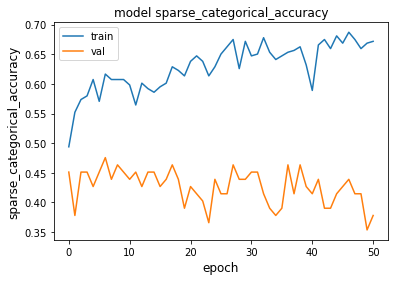

In [166]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [167]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[46 55]
 [45 56]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       101
           1       0.50      0.55      0.53       101

    accuracy                           0.50       202
   macro avg       0.50      0.50      0.50       202
weighted avg       0.50      0.50      0.50       202



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.467


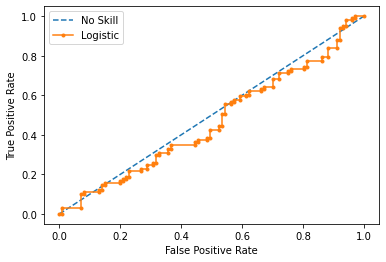

In [168]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# keep probabilities for the positive outcome only
lr_probs = Y_pred[:, 1]
# calculate scores
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [373]:
# model = Sequential()
# model.add(tf.keras.Input(shape=(X_train.shape[1],)))
# model.add(Dense(32))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# model.fit(
#     X_train, y_train,
#     epochs=10000,
#     validation_data=(X_test, y_test),
#     callbacks=[PlotLossesKeras(), es, mc],
#     verbose=0,
#     batch_size=32
# )

# # model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print(f"Accuracy {scores}")

In [82]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42, probability=True)
# clf.fit(X_train, y_train)
# scores = cross_val_score(clf, X_train, y_train, cv=5)
# print(scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.54822335 0.54822335 0.54822335 0.54591837 0.54591837]
0.55 accuracy with a standard deviation of 0.00


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.487


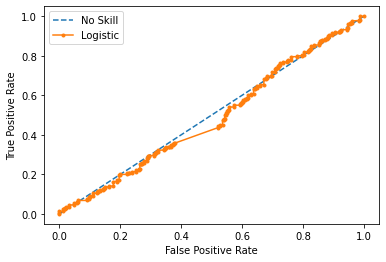

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       265
           1       0.00      0.00      0.00       220

    accuracy                           0.55       485
   macro avg       0.27      0.50      0.35       485
weighted avg       0.30      0.55      0.39       485



c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\thinhpc\anaconda3\envs\p37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



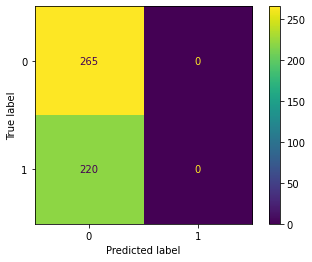

In [83]:
# # predict probabilities
# lr_probs = clf.predict_proba(X_test)
# y_pred = clf.predict(X_test)
# # print(lr_probs)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_probs = [0 for _ in range(len(y_test))]
# ns_auc = roc_auc_score(y_test, ns_probs)
# lr_auc = roc_auc_score(y_test, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
# plot_confusion_matrix(clf, X_test, y_test)  
# print(classification_report(y_test, y_pred))

In [143]:
# generate 2 class dataset
# split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X_new, y_new, test_size=0.5, random_state=2)
# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# trainX = scaler.fit_transform(trainX)
# testX = scaler.transform(testX)
# generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(X, y_test)
# predict probabilities
# lr_probs = model.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_auc = roc_auc_score(testy, ns_probs)
# lr_auc = roc_auc_score(testy, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()
